In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
p = "../../"
sys.path.append(p)
from tools.mydedalustools import calc_helmholtz, open_h5s, concat_levels

SNAPSHOTS_DIR = "/Users/qnicolas/stationaryWave/data/"

import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

In [3]:
def add_wind(ax,u,v,scale=None,key=True,ref=1,unit='m/s',keypos=(0.93,0.95),nm=1):
    """Adds a quiver plot to a matplotlib axis"""
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=nm;m=nm
    Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=scale,transform=ccrs.PlateCarree())
    if key:
        ax.quiverkey(Q, *keypos, ref, label='%i %s'%(ref,unit), labelpos='E', coordinates='axes',color='k')

def wrap_lon(ds,lon='lon'):
    """Add missing longitude point to the dataset by wrapping it around."""
    try: 
        ds[lon]
    except KeyError:
        lon = 'longitude'
    return ds.pad({lon:1}, mode="wrap").assign_coords({lon:ds[lon].pad({lon:1}, mode="reflect", reflect_type="odd")})

def quickplot(field, levels=None, cmap='RdBu_r', ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    field = wrap_lon(field)
    field.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, extend='both')
    ax.coastlines()
    return ax

def prime(field):
    """
    Remove the zonal mean from a field.
    """
    try:
        return field - field.mean('longitude')
    except AttributeError:
        return field - field.mean('lon')
    
def lon_180_to_360(da,longitude='longitude'):
    try:
        da[longitude]
    except KeyError:
        longitude = 'lon'
    da.coords[longitude] = da.coords[longitude] % 360
    da = da.sortby(da[longitude])
    return da

In [7]:
def process_sim(snapshot_id,N=14, sigma_full = 'default',avg = np.array([20,30])):
    sim = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
    if sigma_full=='default':
        dsigma = np.array([0.,0.03,0.041,0.06,0.079,0.094,0.102,0.108,0.109,0.105,0.097,0.082,0.057,0.029,0.007])
        sigma_full = np.cumsum(dsigma)
    sim = concat_levels(sim ,N, sigma_full=sigma_full)

    sim_mean = sim.sel(t=slice(*(avg*24))).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

    for var in ['u','T','lnps','zeta']:
        sim[var+'_mean'] = sim_mean[var]

    return sim.transpose('t','','latitude','longitude','sigma','sigma_stag')

    # helm = calc_helmholtz(sim_mean.u)
    # helm = helm.assign_coords(pressure=helm.sigma * SP.rename(lat = 'latitude',lon = 'longitude').interp_like(helm) / 100)
    # helm_300 = xr.apply_ufunc(lambda sig,y : np.interp(300.,sig,y),
    #                         helm.pressure,
    #                         helm,
    #                         input_core_dims=(('sigma',),('sigma',)),
    #                         vectorize=True)
    # helm_300 = helm_300.rename(u_rot = 'u_rot_300', u_div = 'u_div_300', psi = 'psi_300', div = 'div_300')
    # return xr.merge([sim, helm, helm_300]).transpose('t','','latitude','longitude','sigma','sigma_stag')


# Latest iteration (variable sigma levs, relaxation of zonal mean) with different resolutions

In [176]:
held_T16 = process_sim('stationarywave_14level_T16_held2002_orog_linear_dampedzonalmean_variablesigma')
held_T32 = process_sim('stationarywave_14level_T32_held2002_orog_linear_dampedzonalmean_variablesigma')
held_T64 = process_sim('stationarywave_14level_T64_held2002_orog_linear_dampedzonalmean_variablesigma')

2025-08-11 17:57:41,319 subsystems 0/1 INFO :: Building subproblem matrices 1/15 (~7%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+02/s
2025-08-11 17:57:41,321 subsystems 0/1 INFO :: Building subproblem matrices 2/15 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+02/s
2025-08-11 17:57:41,324 subsystems 0/1 INFO :: Building subproblem matrices 4/15 (~27%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+02/s
2025-08-11 17:57:41,328 subsystems 0/1 INFO :: Building subproblem matrices 6/15 (~40%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+02/s
2025-08-11 17:57:41,331 subsystems 0/1 INFO :: Building subproblem matrices 8/15 (~53%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+02/s
2025-08-11 17:57:41,335 subsystems 0/1 INFO :: Building subproblem matrices 10/15 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+02/s
2025-08-11 17:57:41,338 subsystems 0/1 INFO :: Building subproblem matrices 12/15 (~80%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+02/s
2025-08-11 17:57:41,341 subsystems 0/1 INFO :: Building subproblem matrices

In [23]:
held_T32_nzm = process_sim('stationarywave_14level_T32_held2002_orog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing')


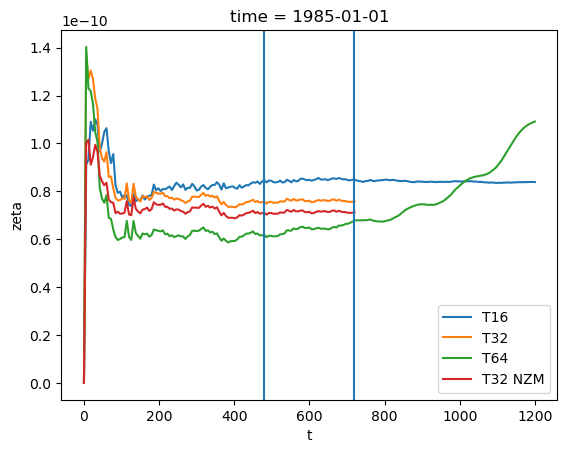

In [115]:
# CONVERGENCE
(held_T16.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T16')
(held_T32.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T32')
(held_T64.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T64')
(held_T32_nzm.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T32 NZM')
plt.legend()
plt.axvline(24*20)
plt.axvline(24*30)

In [44]:
def plot_psiprime(sim):
    _,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    psiprime = wrap_lon(sim['psi_300'])
    psiprime = psiprime - psiprime.mean('longitude')
    psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
    psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
    ax.coastlines()

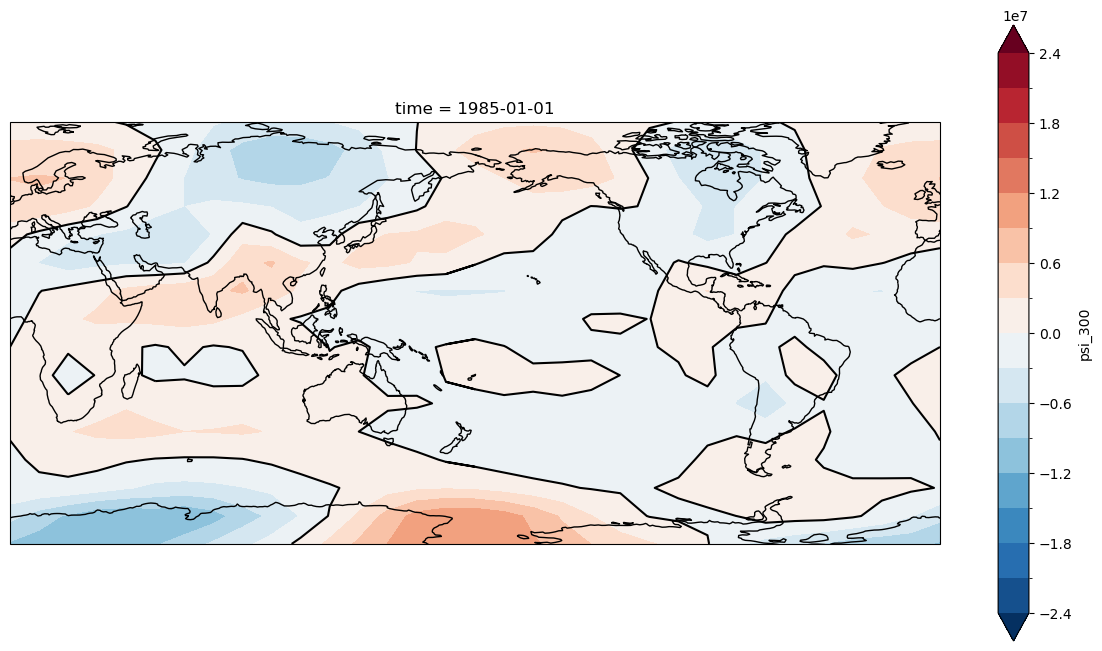

In [45]:
plot_psiprime(held_T16)

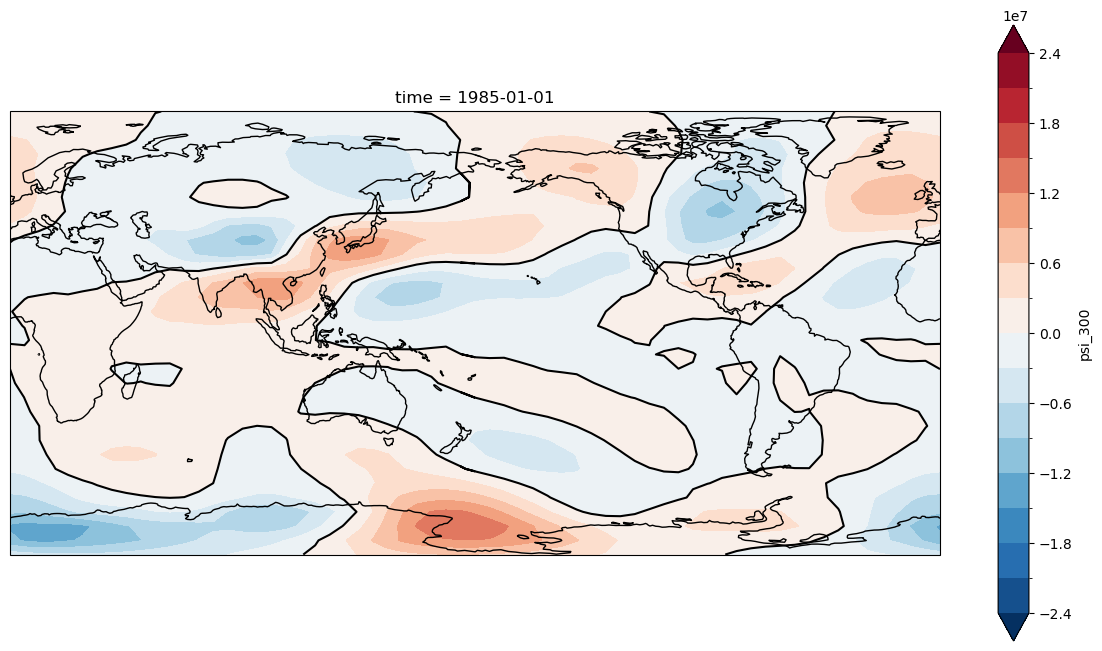

In [46]:
plot_psiprime(held_T32)

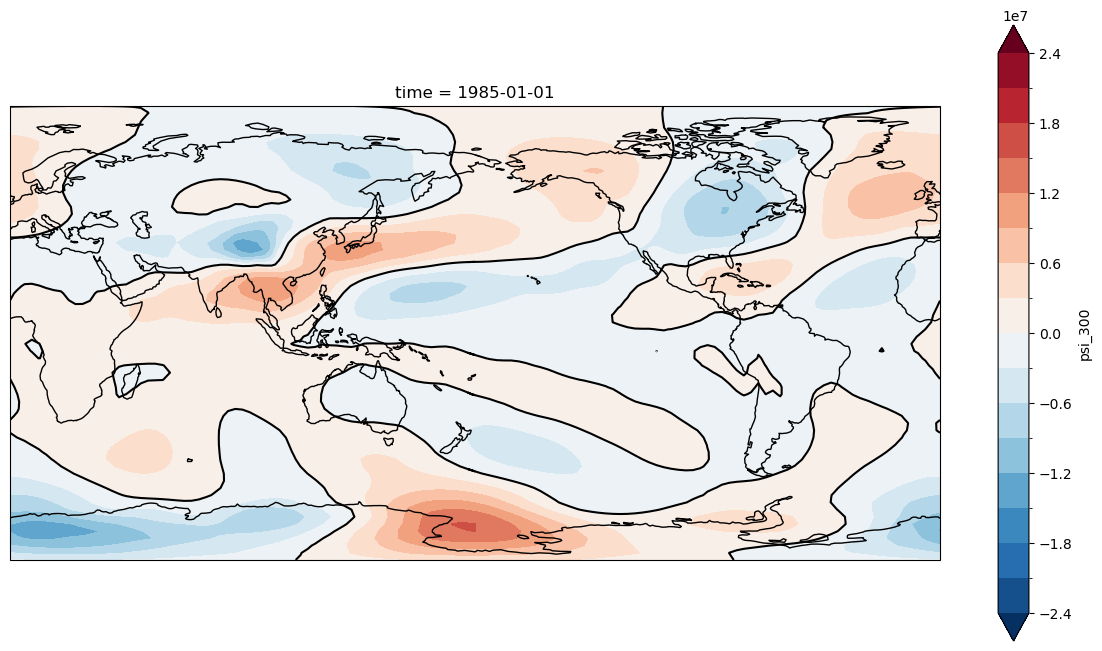

In [47]:
plot_psiprime(held_T64)

# Bill's run

In [138]:
original_plev = xr.open_dataset("output_plev_realorog1pct.nc").isel(day=0)

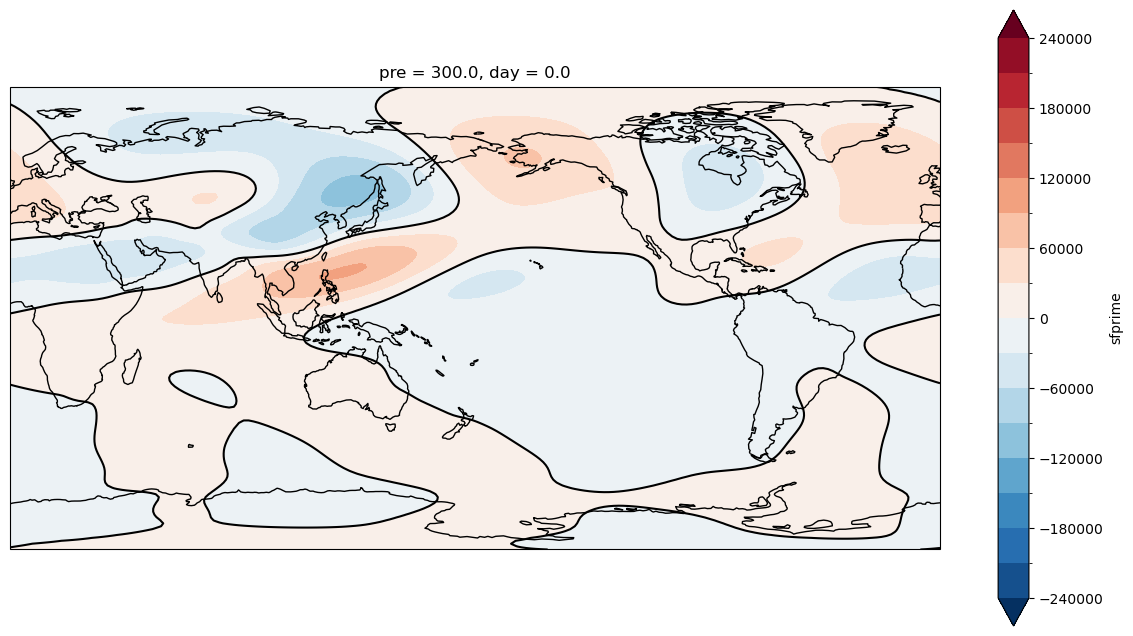

In [ ]:
# orog forcing, 14 variable levs T64, relaxed zonal mean
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = original_plev.sfprime.sel(pre=300)
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e4, cmap = 'RdBu_r',extend='both')#np.arange(-9,9,3) * 1e6
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()

In [121]:
def itp_pres_shitty(field,pres):
    field = field.assign_coords(pressure=field.sigma * SP.rename(lat = 'latitude',lon = 'longitude').interp_like(field) / 100)

    return xr.apply_ufunc(lambda sig,y : np.interp(pres,sig,y),
                            field.pressure,
                            field,
                            input_core_dims=(('sigma',),('sigma',)),
                            vectorize=True)

<GeoAxes: title={'center': 'time = 1985-01-01'}, xlabel='longitude', ylabel='latitude'>

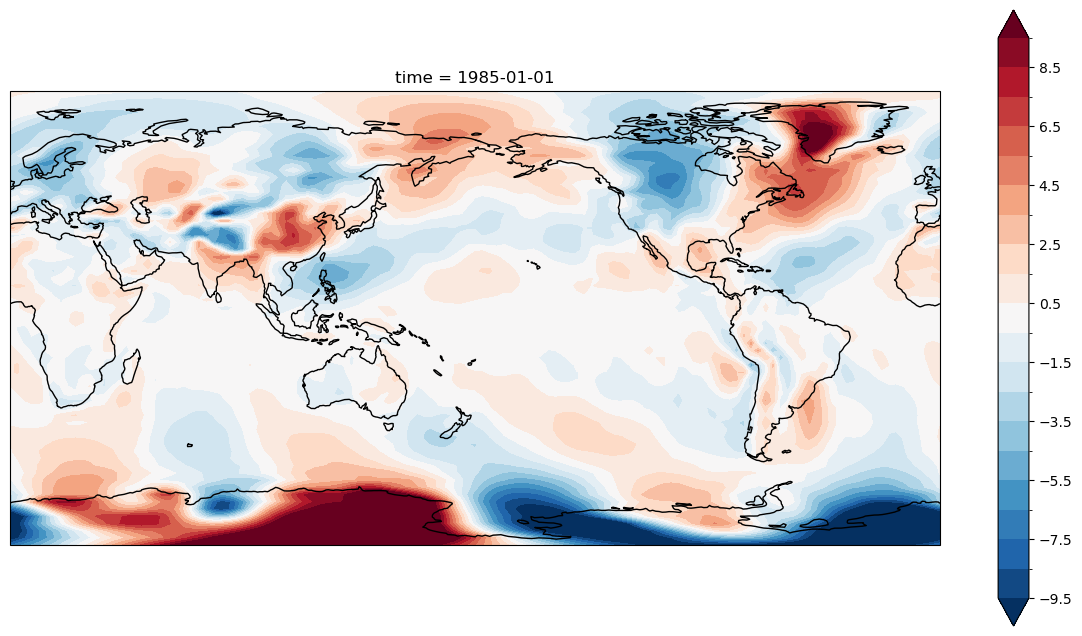

In [122]:
quickplot(itp_pres_shitty(-held_T64.u_mean[1],300),levels=np.arange(-9.5,9.6,1))

<GeoAxes: title={'center': 'pre = 300.0, day = 0.0'}, xlabel='lon', ylabel='lat'>

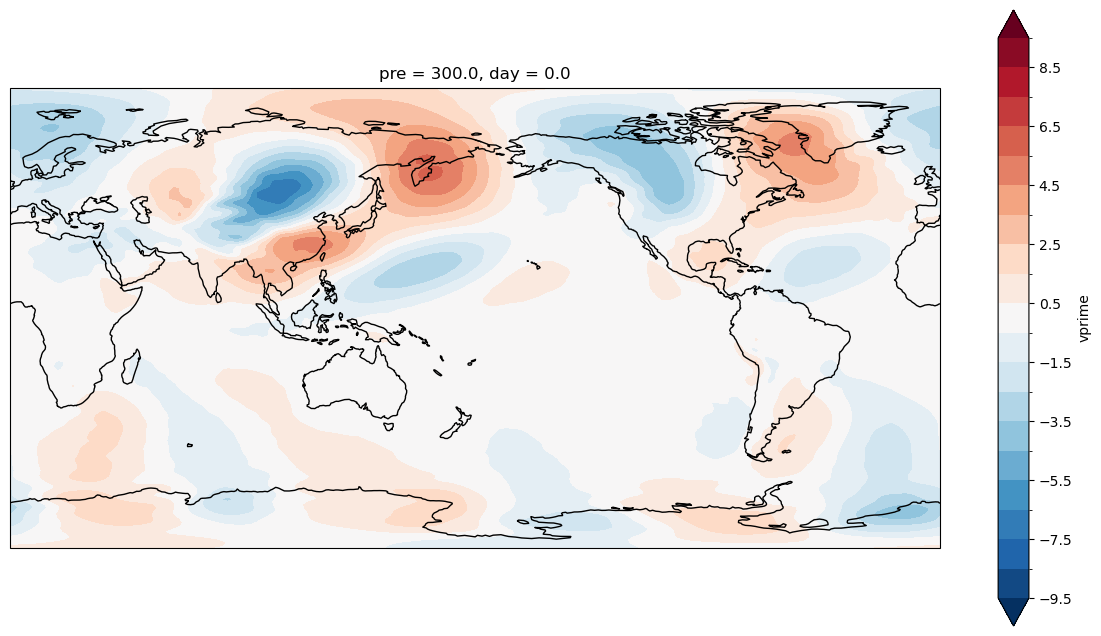

In [63]:
quickplot(original_plev.vprime[0].sel(pre=300) * 100,levels=np.arange(-9.5,9.6,1))

# Various tests with sigma lev data

In [10]:
original_sigma = xr.open_dataset("output_sigma_realorog1pct.nc").isel(T=0).rename(X='longitude', Y='latitude',lev='sigma')
original_sigma_itp = original_sigma.interp_like(held_T32_nzm.sigma)

## Orography

<GeoAxes: xlabel='longitude', ylabel='latitude'>

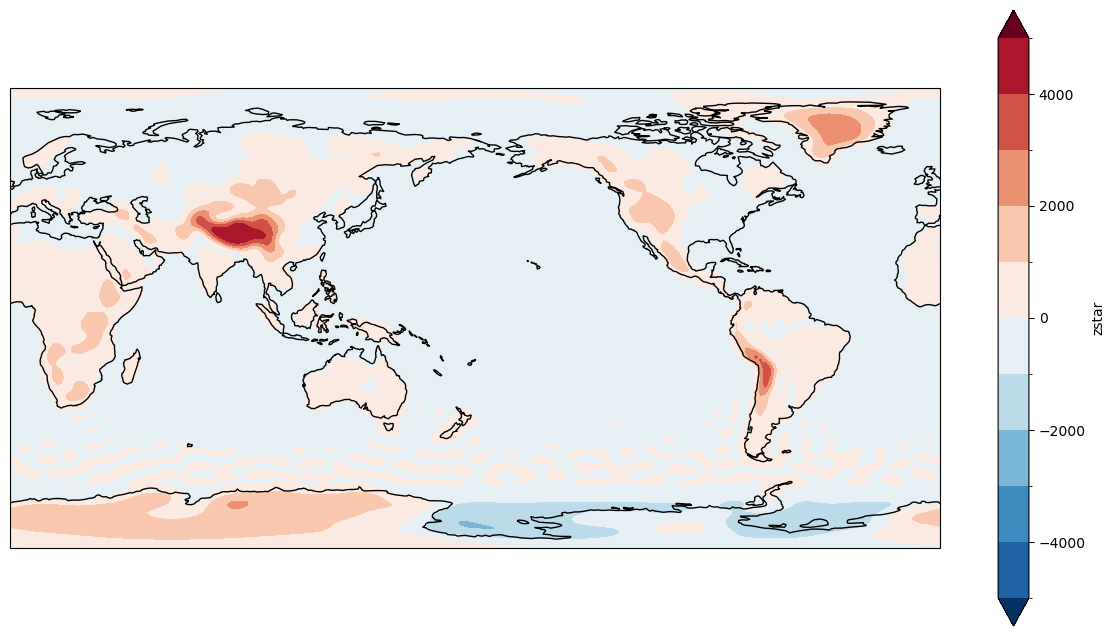

In [82]:
quickplot(original_sigma.zstar * 100,levels = np.linspace(-5000,5000,11))

<GeoAxes: title={'center': 't = 0.0, sim_time = 0.0, wall_time = 319.0, tim...'}, xlabel='longitude', ylabel='latitude'>

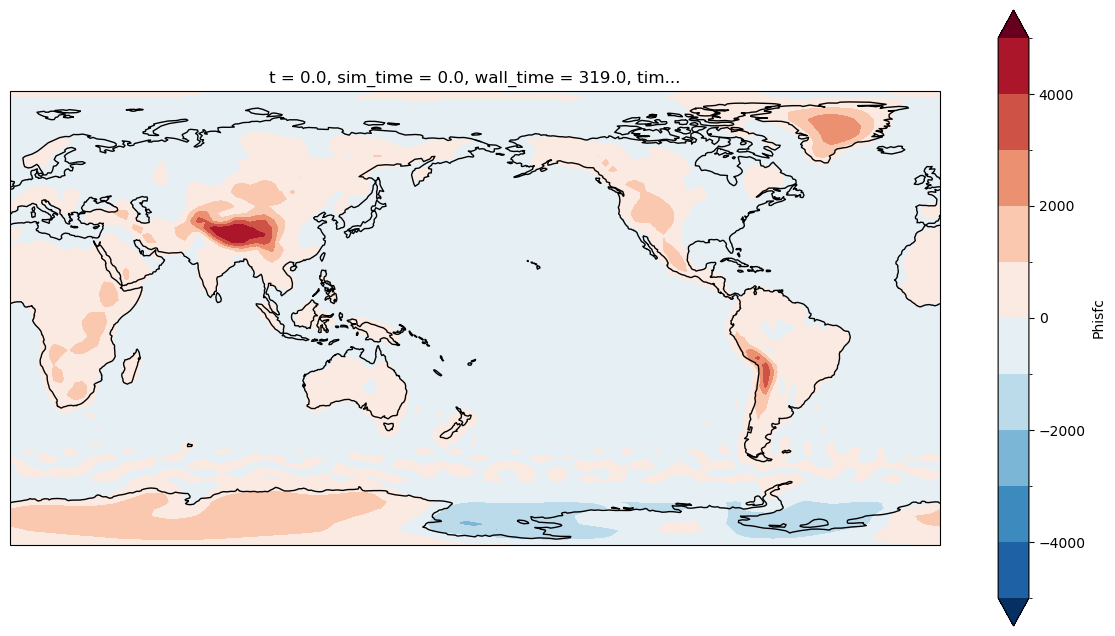

In [83]:
quickplot(prime(held_T64.Phisfc[0]/9.81),levels = np.linspace(-5000,5000,11))

## Temperature perturbations

<GeoAxes: title={'center': 'sigma = 0.355, time = 1985-01-01'}, xlabel='longitude', ylabel='latitude'>

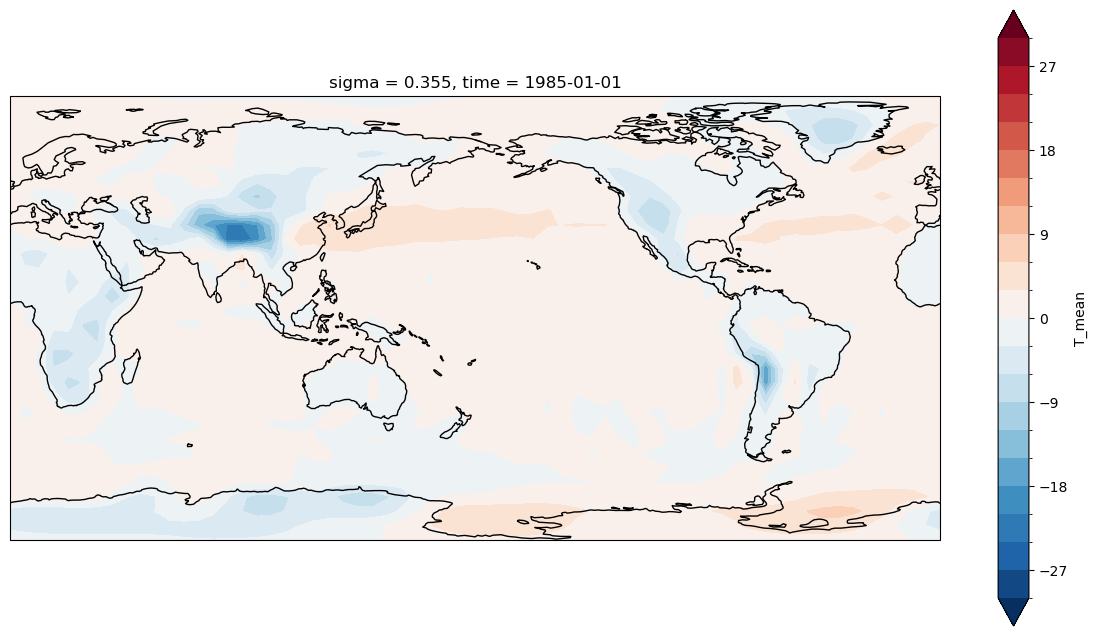

In [117]:
quickplot(held_T32_nzm.T_mean.sel(sigma=0.355,method='nearest'),levels=np.linspace(-30,30,21))

<GeoAxes: title={'center': 'T = 12, sigma = 0.355'}, xlabel='longitude', ylabel='latitude'>

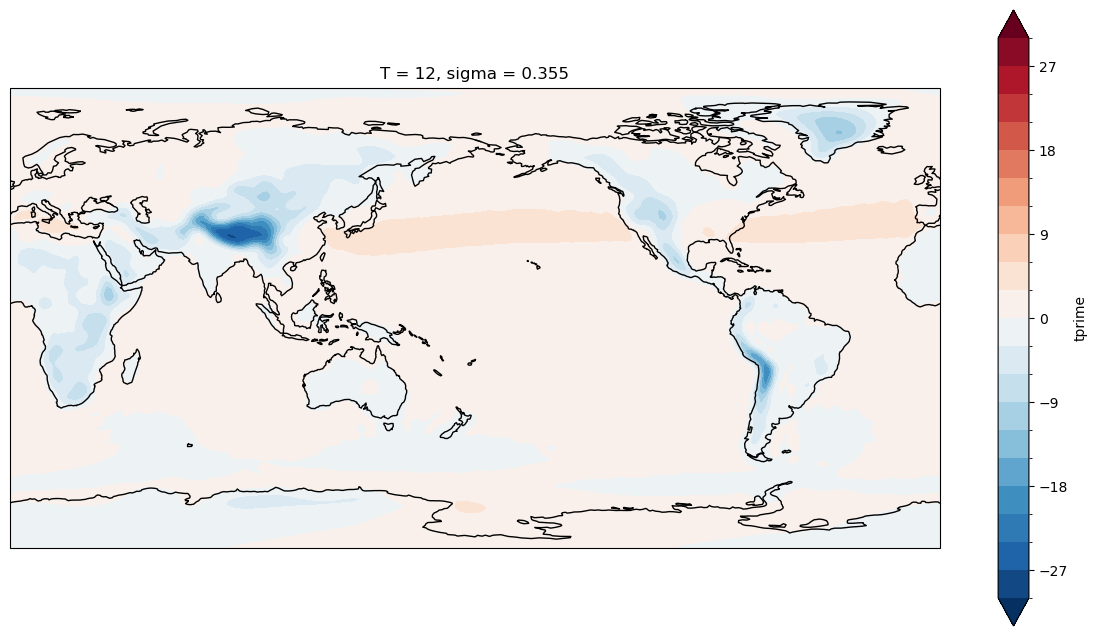

In [ ]:
quickplot(100*original_sigma_itp.tprime.sel(sigma=0.355,method='nearest'),levels=np.linspace(-30,30,21))

## log-sfc pressure perturbations

<GeoAxes: xlabel='longitude', ylabel='latitude'>

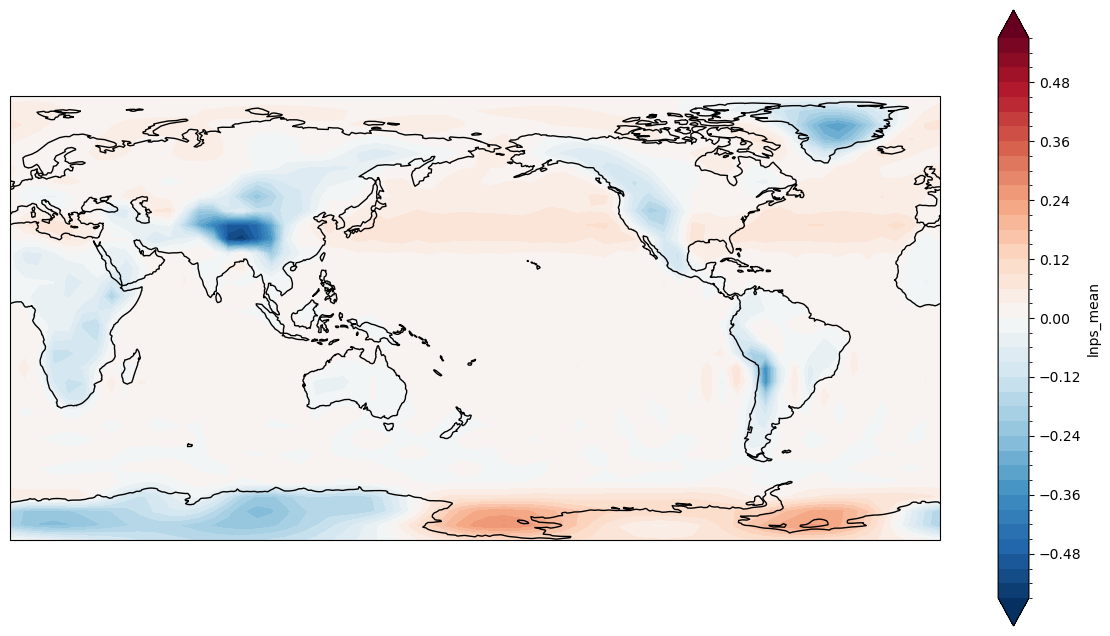

In [20]:
quickplot(held_T32_nzm.lnps_mean,levels=41)

<GeoAxes: title={'center': 'T = 12'}, xlabel='longitude', ylabel='latitude'>

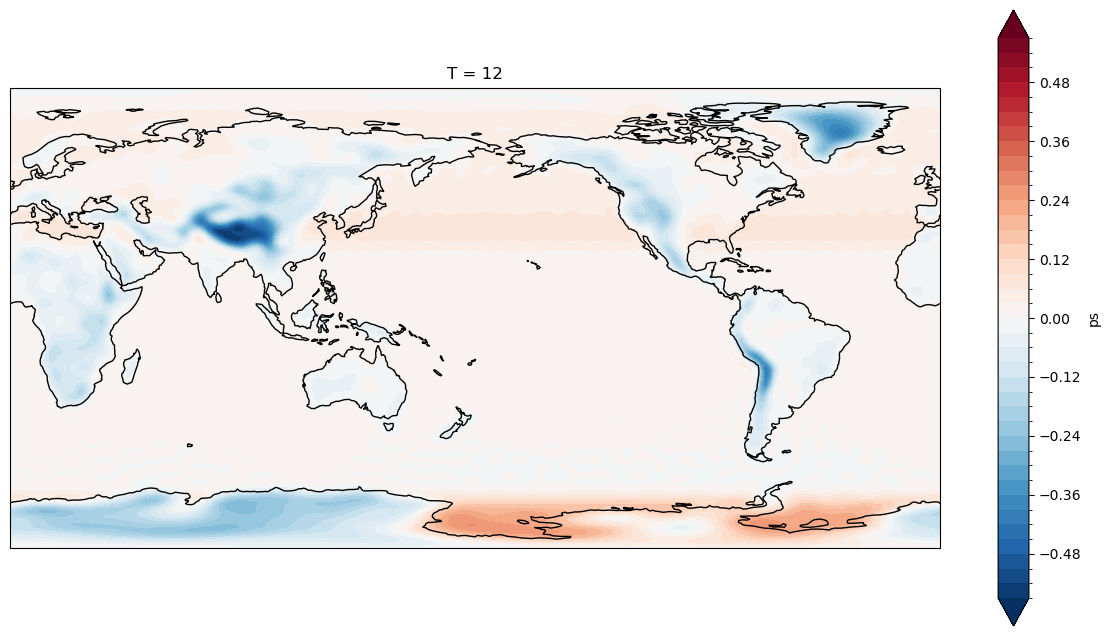

In [19]:
quickplot(original_sigma_itp.ps * 100,levels=41)

## Vorticity perturbations

<GeoAxes: title={'center': 'sigma = 0.355'}, xlabel='longitude', ylabel='latitude'>

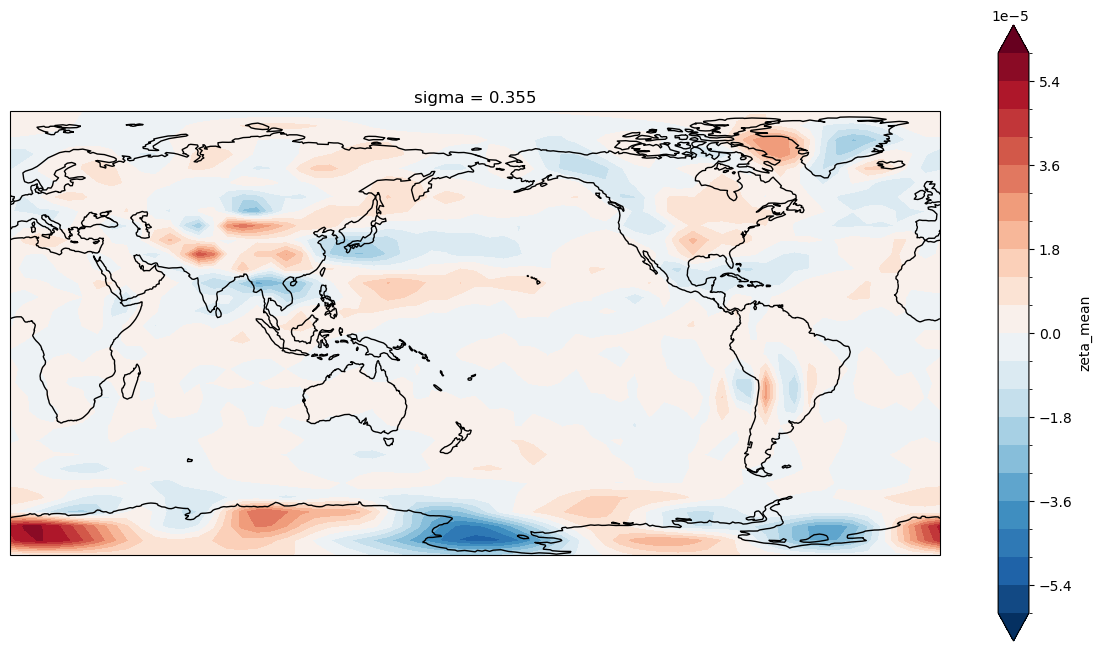

In [ ]:
quickplot(held_T32_nzm.zeta_mean.sel(sigma=0.355,method='nearest'),levels=np.linspace())

<GeoAxes: title={'center': 'T = 12, sigma = 0.355'}, xlabel='longitude', ylabel='latitude'>

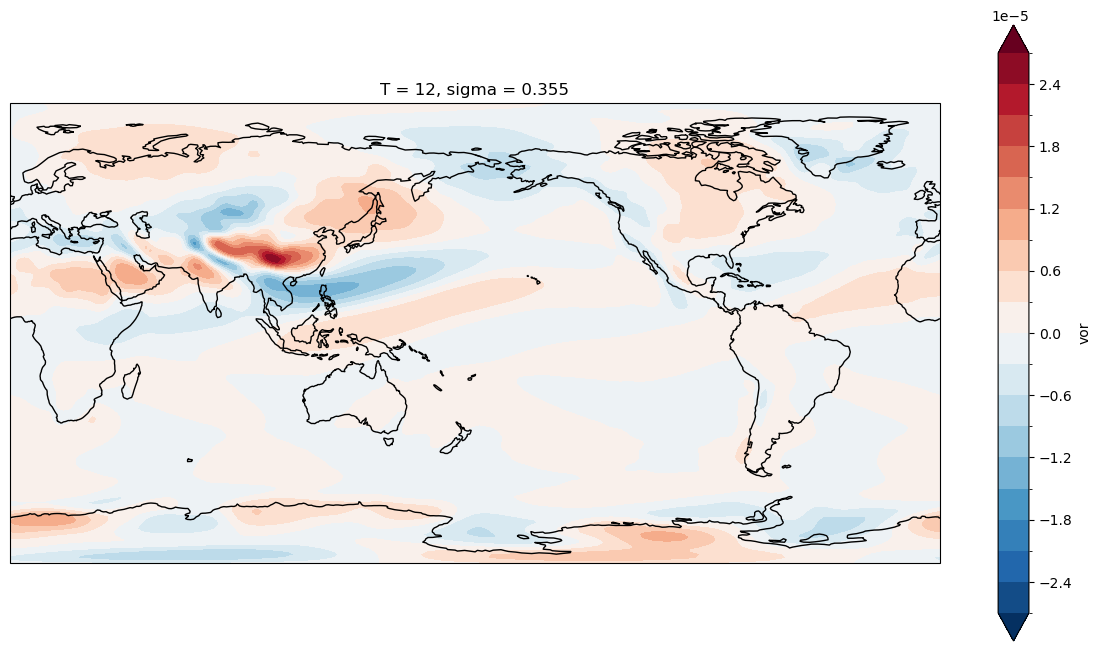

In [25]:
quickplot(100*original_sigma_itp.vor.sel(sigma=0.355,method='nearest'),levels=21)

# Re-doing the pressure itp

In [180]:
def itp_pres(sim,field,pres):
    ps = 1e3 * np.exp(sim.lnpsbar.isel(t=0,longitude=0) + sim.lnps_mean)
    field = field.assign_coords(pressure=field.sigma * ps)
    return xr.apply_ufunc(lambda sig,y : np.interp(pres,sig,y),
                            field.pressure,
                            field,
                            input_core_dims=(('sigma',),('sigma',)),
                            vectorize=True)


In [182]:
def itp_pres_basicstate(sim,field,pres):
    psbar = 1e3 * np.exp(sim.lnpsbar.isel(t=0,longitude=0))
    field = field.assign_coords(pressure=field.sigma * psbar)
    return xr.apply_ufunc(lambda sig,y : np.interp(pres,sig,y),
                            field.pressure,
                            field,
                            input_core_dims=(('sigma',),('sigma',)),
                            vectorize=True)

<GeoAxes: title={'center': 'sigma = 0.355, time = 1985-01-01'}, xlabel='longitude', ylabel='latitude'>

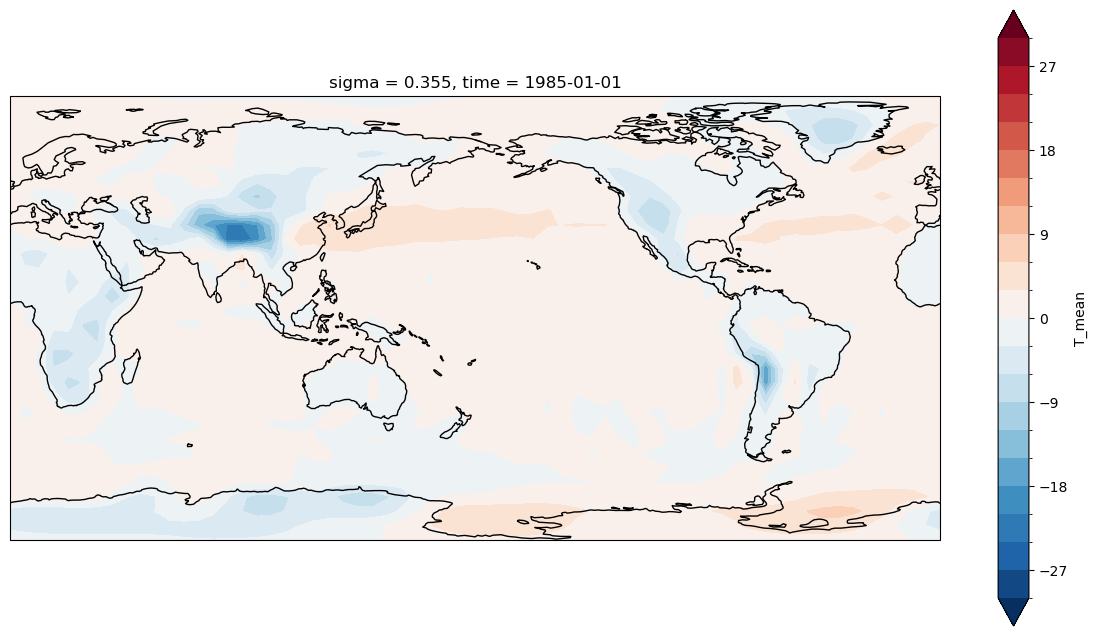

In [ ]:
quickplot(held_T32_nzm.T_mean.sel(sigma=0.355,method='nearest'),levels=np.linspace(-30,30,21))

<GeoAxes: title={'center': 'time = 1985-01-01, t = 0.0, sim_time = 0.0, wal...'}, xlabel='longitude', ylabel='latitude'>

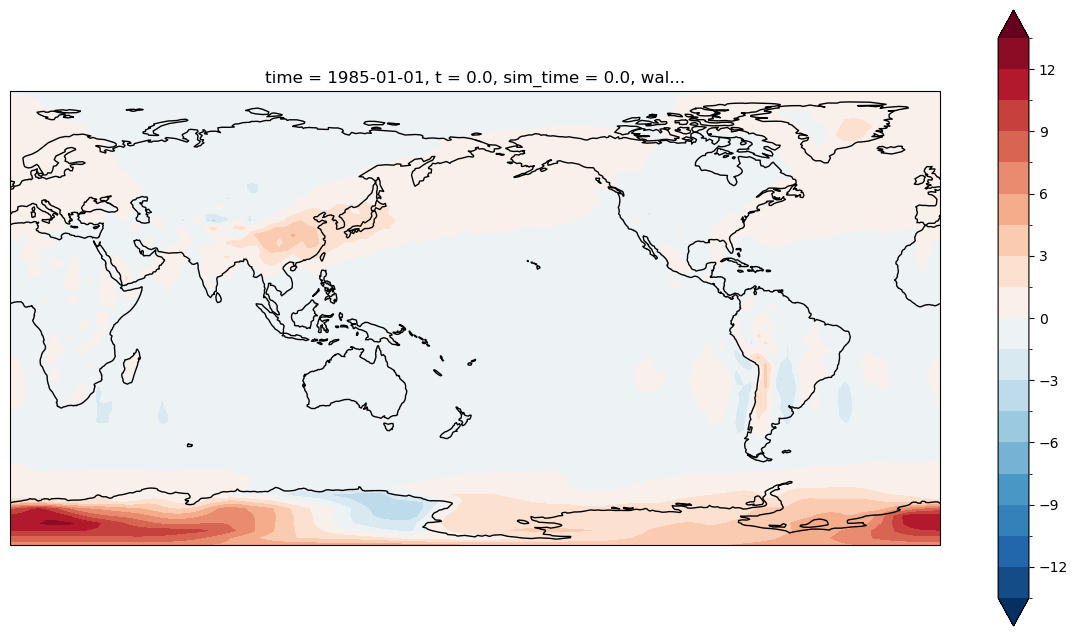

In [184]:
sim  = held_T64
Tbar = sim.Tbar.isel(t=0,longitude=0)
Ttot = sim.T_mean + Tbar

Ttot_itp = itp_pres(sim,Ttot,300)
Tin_itp = itp_pres_basicstate(sim,Tbar,300)

quickplot(Ttot_itp - Tin_itp,levels=21)

<GeoAxes: title={'center': 'time = 1985-01-01, t = 0.0, sim_time = 0.0, wal...'}, xlabel='longitude', ylabel='latitude'>

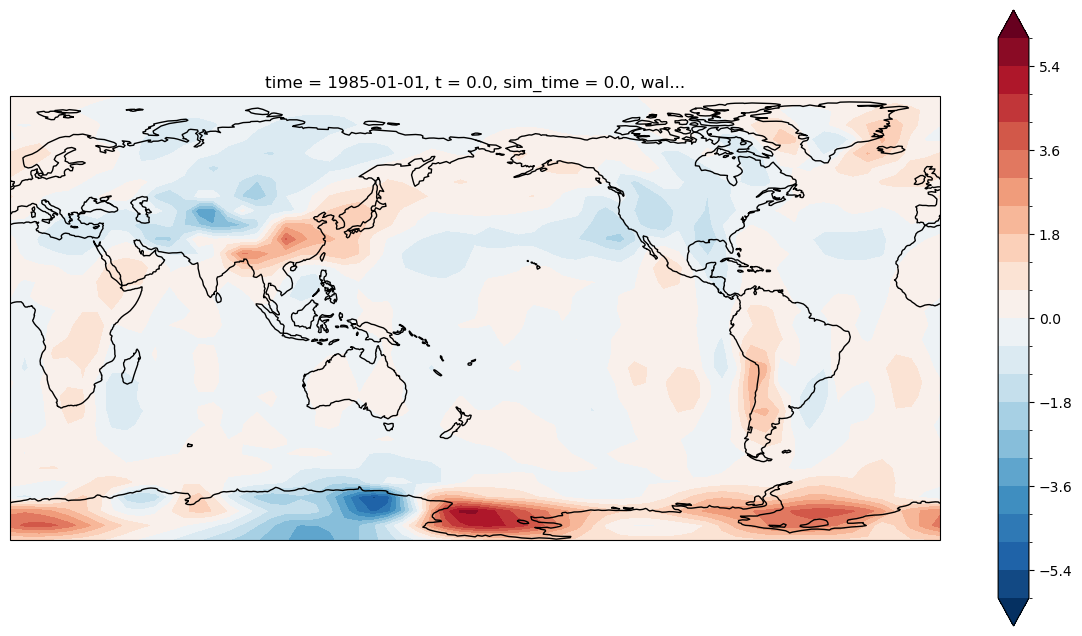

In [185]:
sim  = held_T32_nzm
Tbar = sim.Tbar.isel(t=0,longitude=0)
Ttot = sim.T_mean + Tbar

Ttot_itp = itp_pres(sim,Ttot,300)
Tin_itp = itp_pres_basicstate(sim,Tbar,300)

quickplot(Ttot_itp - Tin_itp,levels=21)

<GeoAxes: title={'center': 'pre = 300.0, day = 0.0'}, xlabel='lon', ylabel='lat'>

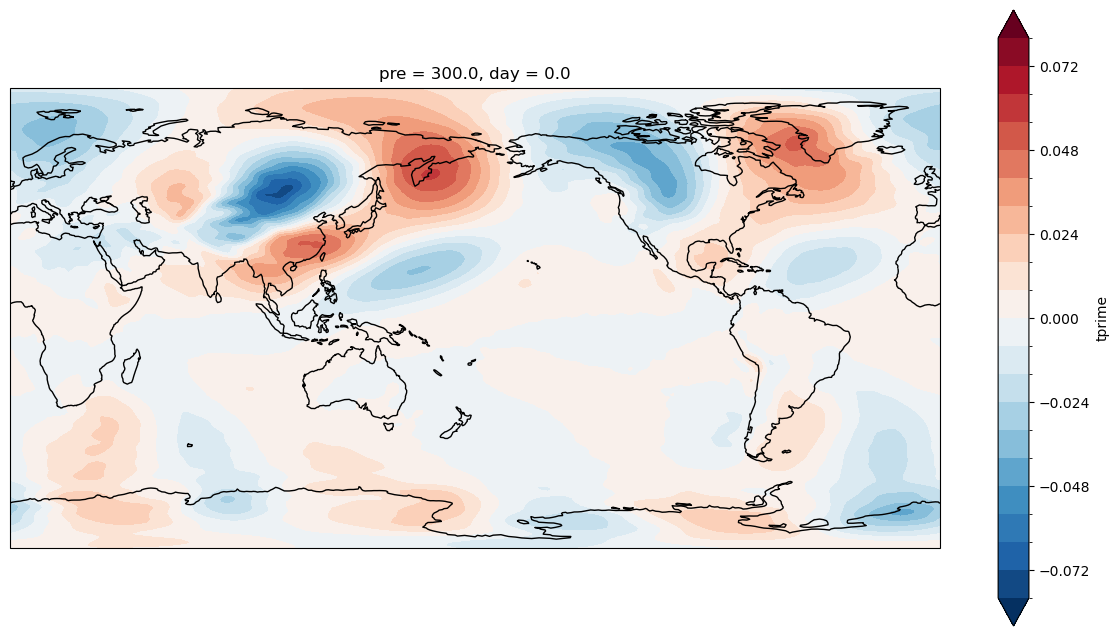

In [158]:
quickplot(original_plev.tprime.sel(pre=300),levels=21)

In [154]:
original_plev

<xarray.Dataset> Size: 75MB
Dimensions:    (lon: 192, lat: 160, pre: 17)
Coordinates:
  * lon        (lon) float32 768B 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * lat        (lat) float32 640B -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * pre        (pre) float32 68B 10.0 20.0 30.0 50.0 ... 700.0 850.0 925.0 1e+03
    day        float32 4B 0.0
Data variables: (12/37)
    ps         (lat, lon) float32 123kB ...
    ubar       (pre, lat, lon) float32 2MB ...
    vbar       (pre, lat, lon) float32 2MB ...
    tbar       (pre, lat, lon) float32 2MB ...
    heating    (pre, lat, lon) float32 2MB ...
    div        (pre, lat, lon) float32 2MB ...
    ...         ...
    vortprime  (pre, lat, lon) float32 2MB ...
    vortbarin  (pre, lat, lon) float32 2MB ...
    divtot     (pre, lat, lon) float32 2MB ...
    divbar     (pre, lat, lon) float32 2MB ...
    divprime   (pre, lat, lon) float32 2MB ...
    divbarin   (pre, lat, lon) float32 2MB ...

<GeoAxes: title={'center': 'pre = 300.0, day = 0.0'}, xlabel='lon', ylabel='lat'>

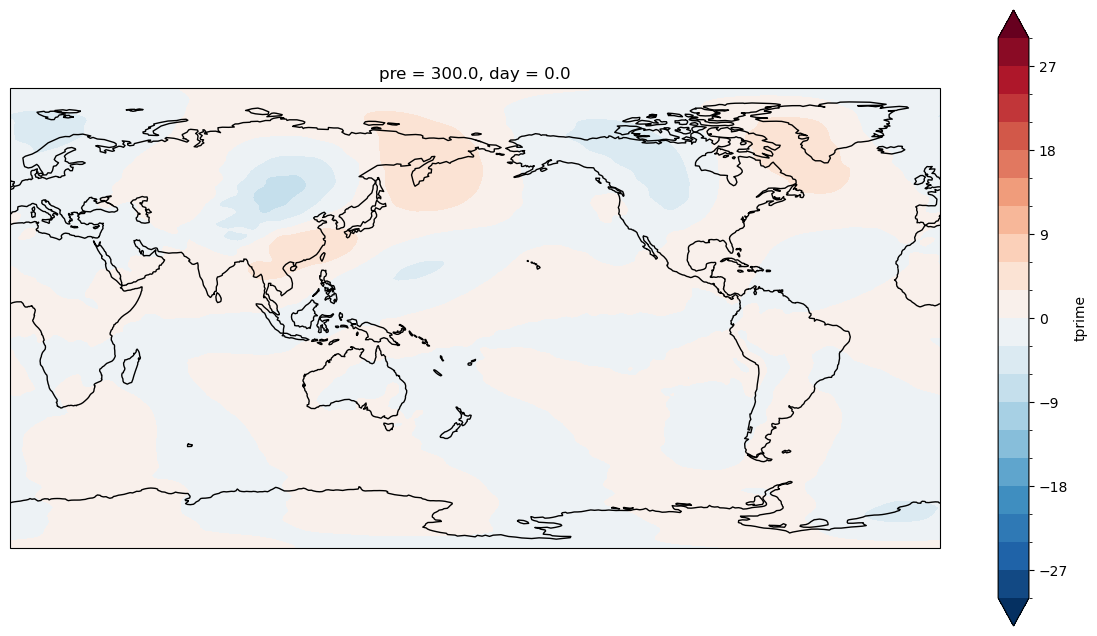

In [ ]:
quickplot(original_plev.tprime.sel(pre=300) * 100,levels=np.linspace(-30,30,21))

<xarray.DataArray 'tprime' (lat: 160, lon: 192)> Size: 123kB
[30720 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 768B 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 640B -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
    pre      float32 4B 300.0
    day      float32 4B 0.0

# Bill's version has 24 sigma levs

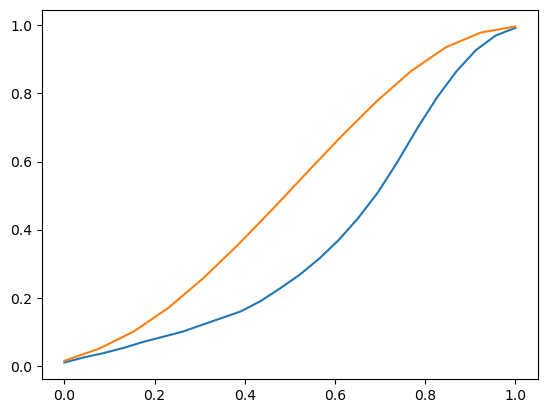

In [89]:
plt.plot(np.linspace(0,1,24),original_sigma.lev)
plt.plot(np.linspace(0,1,14),held_T32.sigma)

# Ideal Tibet 

In [8]:
ideal_T32 = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing')


In [9]:
ideal_T32_2 = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2')


In [10]:
ideal_T32_3 = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2_dealias2')


In [52]:
ideal_T32_2p1 = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2_secondtest')


In [11]:
ideal_T32_nosigdot = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2_nosigmadot')


In [12]:
ideal_T32_nosigdot_x2 = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2_nosigmadot_x2')


In [13]:
ideal_T32_nosigdot_div10 = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2_nosigmadot_div10')


In [48]:
ideal_T32_strongsigdot = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2_strongsigmadot')


In [49]:
ideal_T32_strongdiff = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2_strongdiff')


In [60]:
ideal_T32_weakdiff = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2_weakdiff')


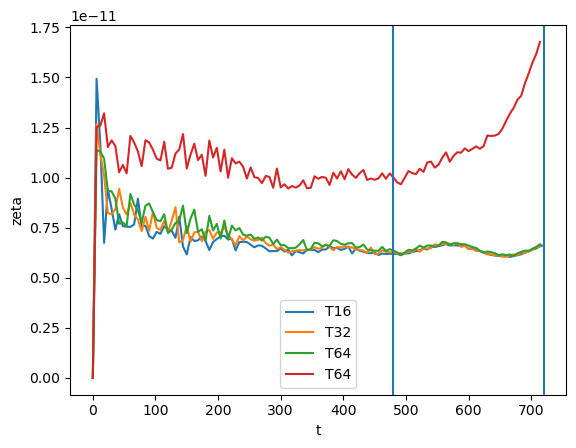

In [61]:
# CONVERGENCE
(ideal_T32.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T16')
(1e4 * ideal_T32_2.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T32')
(1e4 * ideal_T32_3.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T64')
(1e4 * ideal_T32_weakdiff.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T64')

plt.legend()
plt.axvline(24*20)
plt.axvline(24*30)

In [16]:
ideal_sigma = xr.open_dataset("output_sigma_idealorog1pct.nc").isel(T=0).rename(X='longitude', Y='latitude',lev='sigma')
ideal_sigma_itp = ideal_sigma.interp_like(ideal_T32.sigma)

## basic states

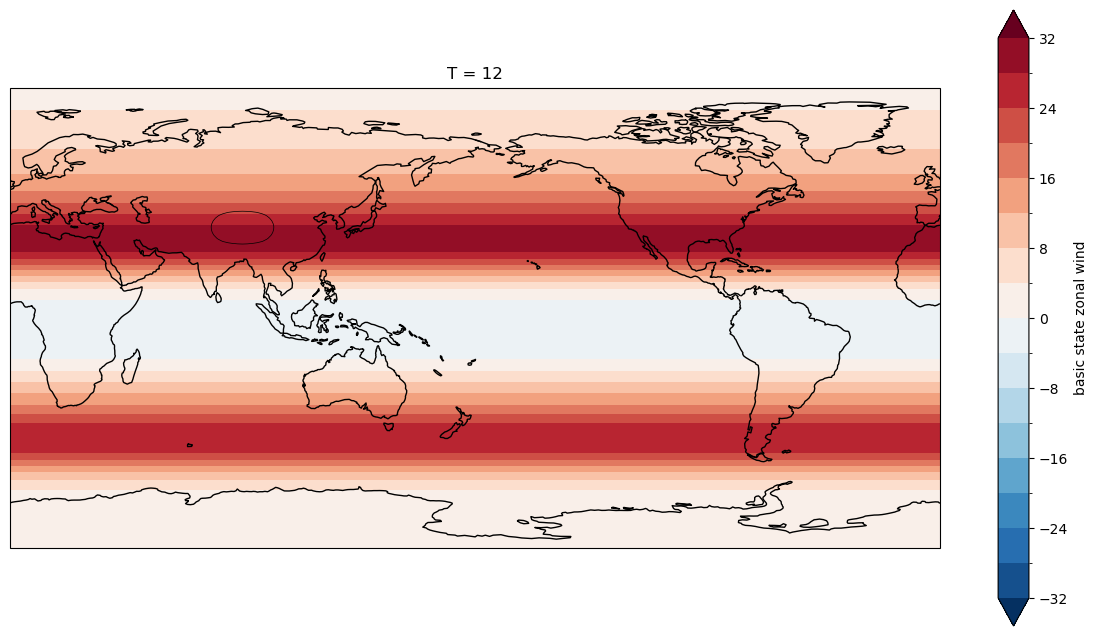

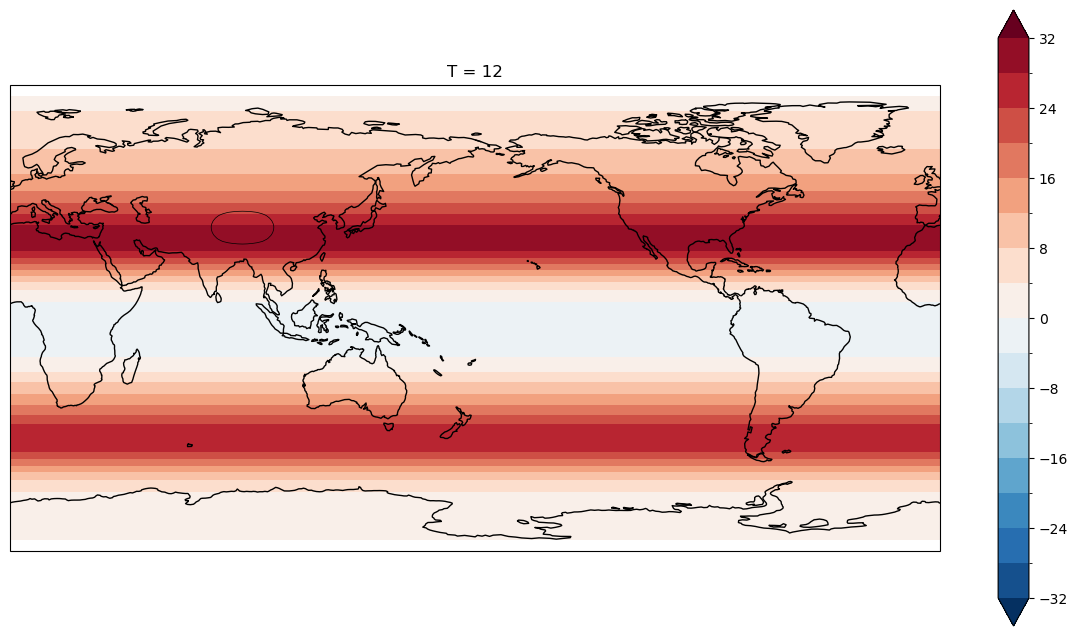

In [66]:
ax = quickplot((ideal_sigma_itp.ubar).sel(sigma=0.355,method='nearest'),levels=21)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

ax = quickplot(ideal_T32_2.ubar[0,0].sel(sigma=0.355,method='nearest').isel(longitude=0) * ideal_T32_2.longitude**0,levels=21)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

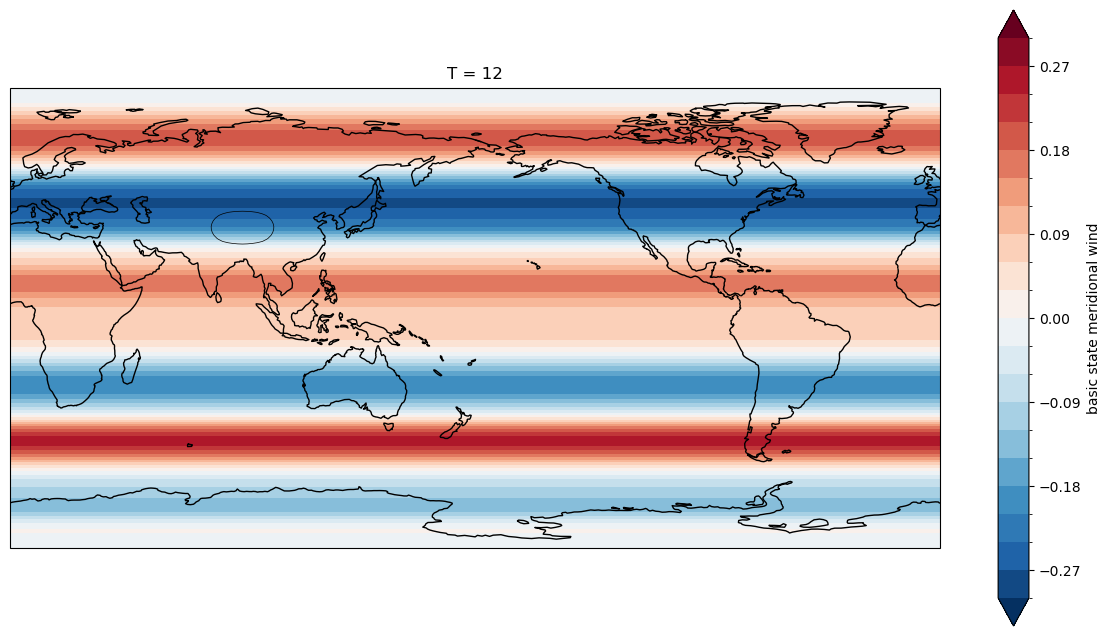

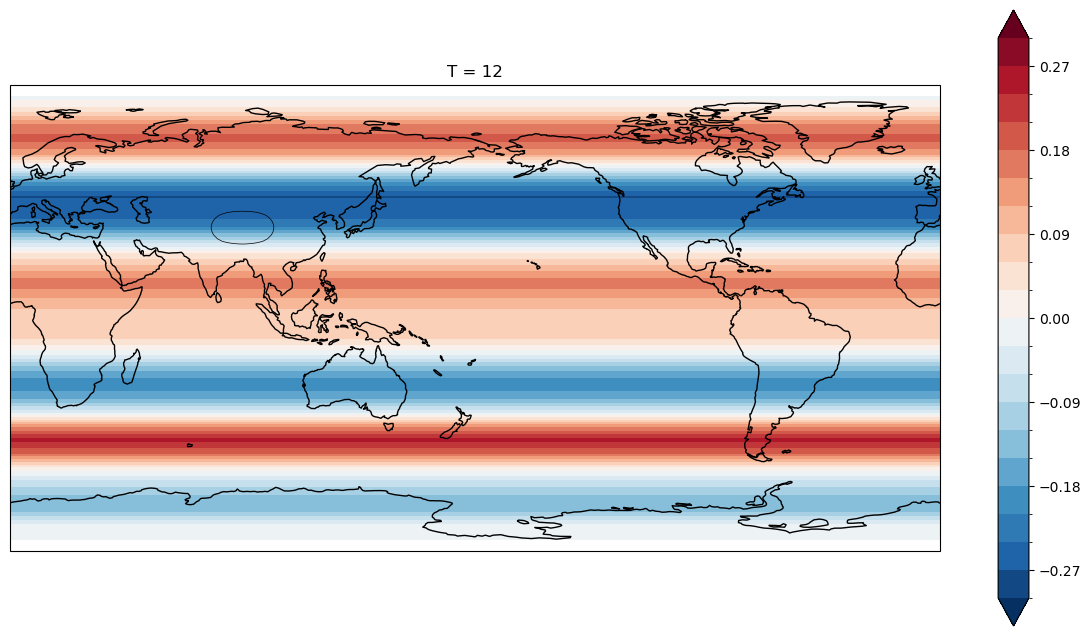

In [81]:
ax = quickplot((ideal_sigma_itp.vbar).sel(sigma=0.355,method='nearest'),levels=21)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

ax = quickplot(-ideal_T32_2.ubar[0,1].sel(sigma=0.355,method='nearest').isel(longitude=0) * ideal_T32_2.longitude**0,levels=21)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

In [85]:
test=xr.open_dataset("output_plev_idealorog1pct.nc").isel(day=0).rename(lon='longitude', lat='latitude')
test


<xarray.Dataset> Size: 75MB
Dimensions:    (longitude: 192, latitude: 160, pre: 17)
Coordinates:
  * longitude  (longitude) float32 768B 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * latitude   (latitude) float32 640B -89.14 -88.03 -86.91 ... 88.03 89.14
  * pre        (pre) float32 68B 10.0 20.0 30.0 50.0 ... 700.0 850.0 925.0 1e+03
    day        float32 4B 0.0
Data variables: (12/37)
    ps         (latitude, longitude) float32 123kB ...
    ubar       (pre, latitude, longitude) float32 2MB ...
    vbar       (pre, latitude, longitude) float32 2MB ...
    tbar       (pre, latitude, longitude) float32 2MB ...
    heating    (pre, latitude, longitude) float32 2MB ...
    div        (pre, latitude, longitude) float32 2MB ...
    ...         ...
    vortprime  (pre, latitude, longitude) float32 2MB ...
    vortbarin  (pre, latitude, longitude) float32 2MB ...
    divtot     (pre, latitude, longitude) float32 2MB ...
    divbar     (pre, latitude, longitude) float32 2MB ...
    divprime   (pre, latitude, longitude) float32 2MB ...
    divbarin   (pre, latitude, longitude) float32 2MB ...

In [89]:
pstest = 1e3 * np.exp(ideal_T32_2.lnpsbar[0].isel(longitude=0) + ideal_T32_2.lnps_mean)

<GeoAxes: title={'center': 't = 0.0, sim_time = 0.0, wall_time = 84.61, tim...'}, xlabel='longitude', ylabel='latitude'>

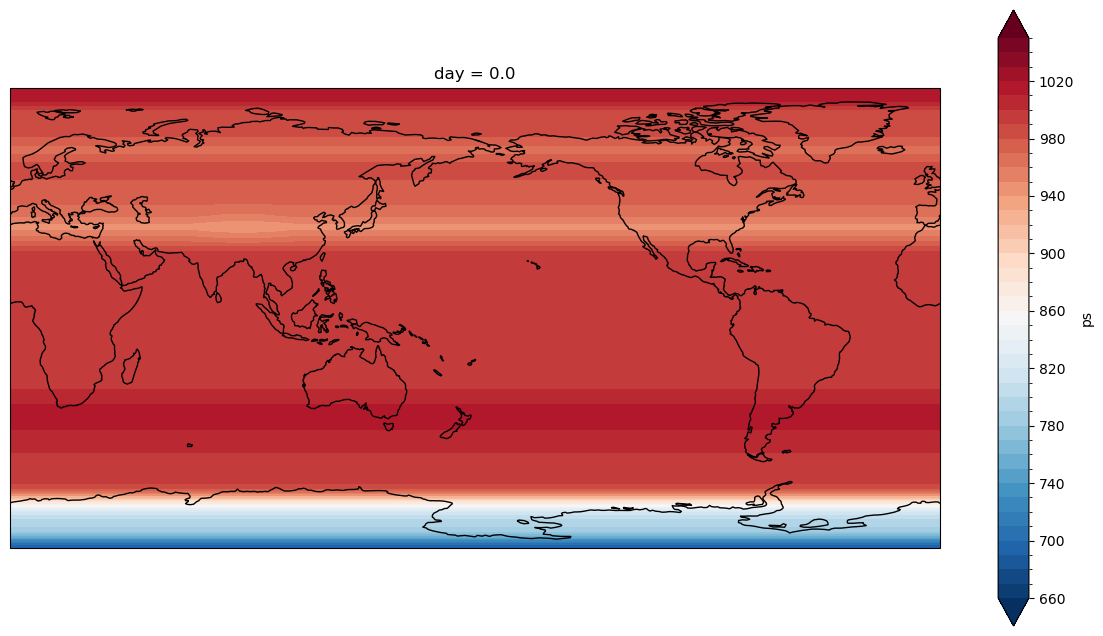

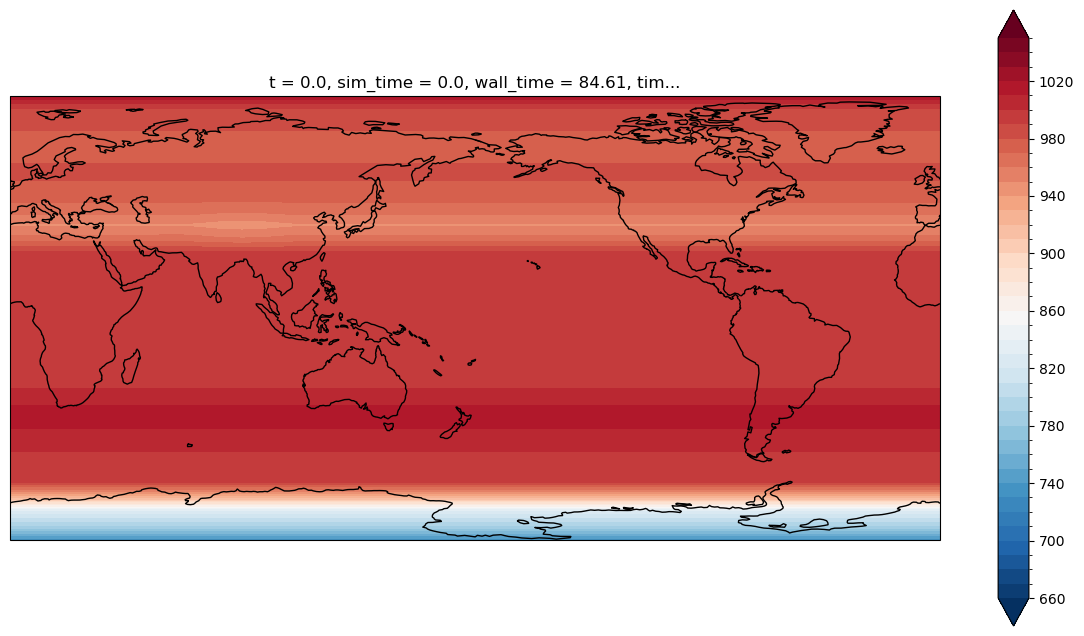

In [94]:
quickplot(test.ps,levels = np.arange(660,1060,10))
quickplot(pstest,levels = np.arange(660,1060,10))

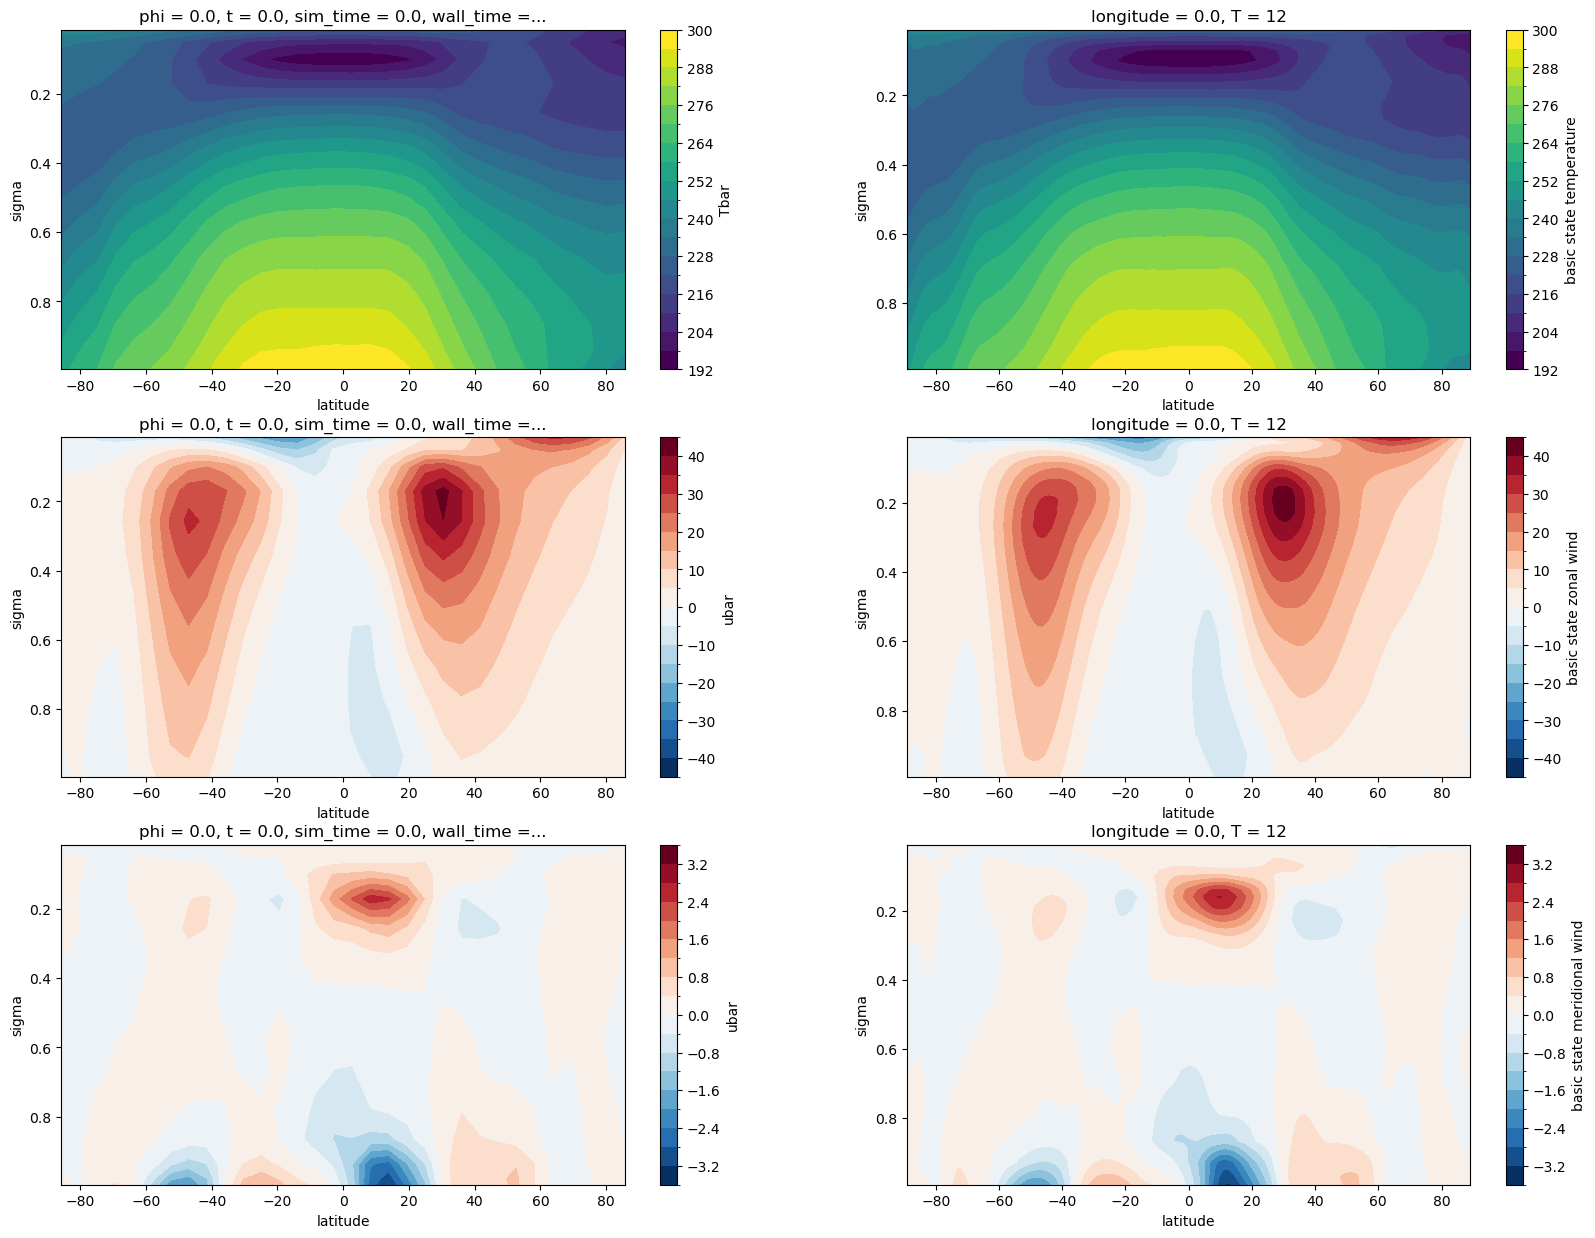

In [99]:
# basic state
_,axs = plt.subplots(3,2,figsize=(20,15))
basicstate = ideal_T32_2.isel(t=0,longitude=0)
for i,(ax,var) in enumerate(zip(axs[:,0],(basicstate.Tbar,basicstate.ubar[0],-basicstate.ubar[1]))):
    var.plot.contourf(ax=ax,y='sigma',yincrease=False,levels=21)

for i,(ax,var) in enumerate(zip(axs[:,1],(ideal_sigma.tbar,ideal_sigma.ubar,ideal_sigma.vbar))):
    var = var.isel(longitude=0)
    var.plot.contourf(ax=ax,y='sigma',yincrease=False,levels=21)

## Perturbations

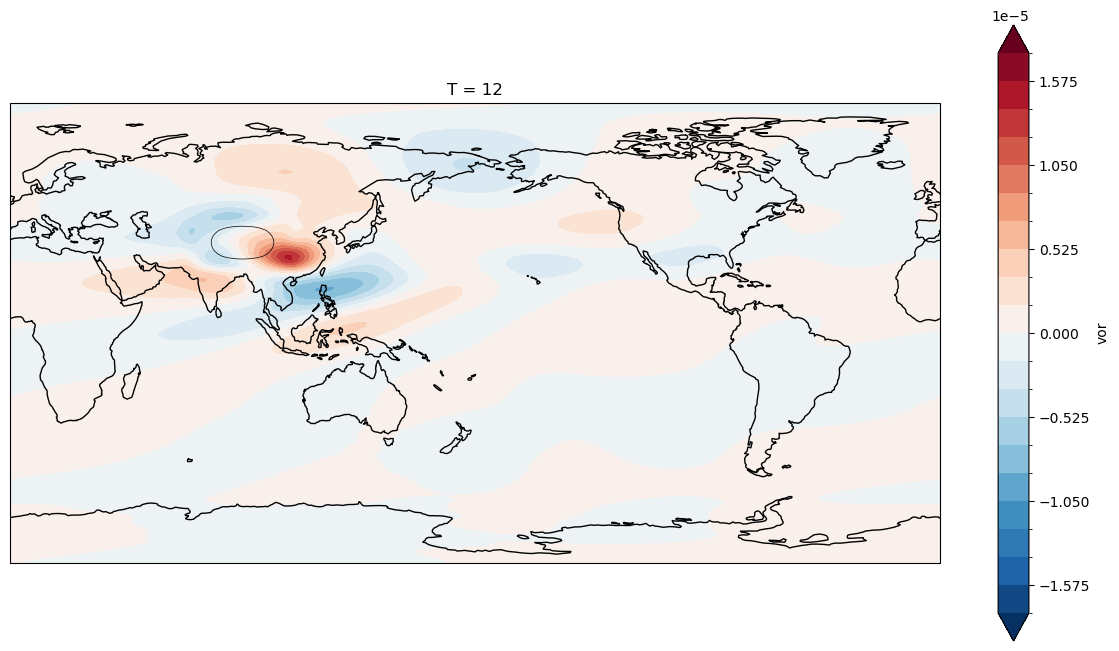

In [56]:
ax = quickplot(100*ideal_sigma_itp.vor.sel(sigma=0.355,method='nearest'),levels=np.linspace(-1.75,1.75,21) * 1e-5)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

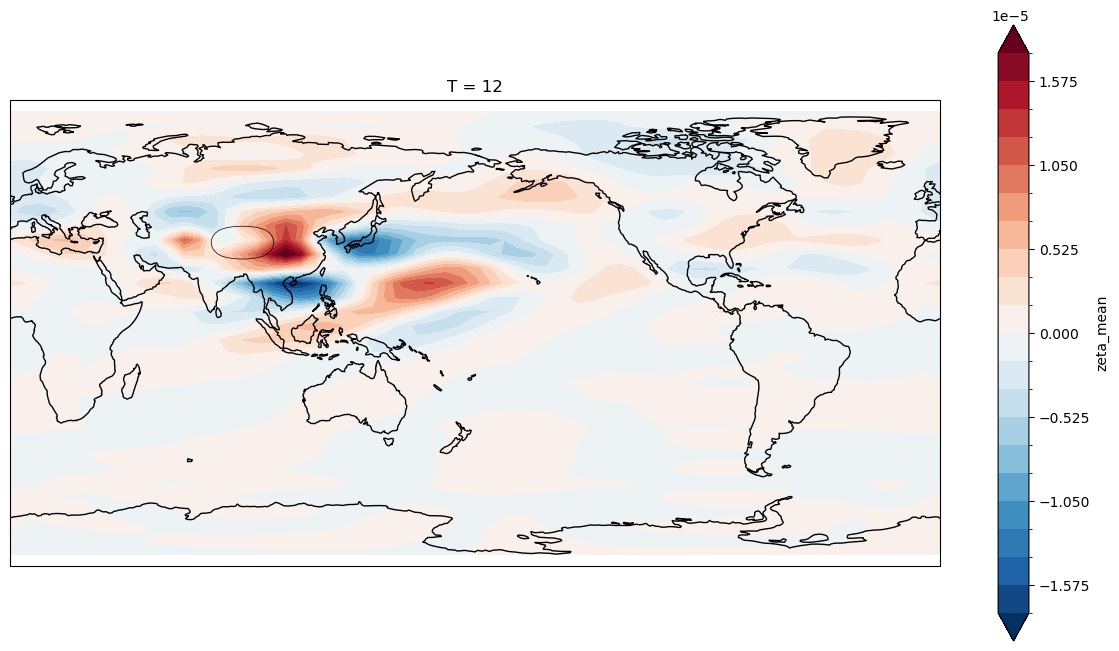

In [58]:
ax = quickplot(100 * ideal_T32_2.zeta_mean.sel(sigma=0.355,method='nearest'),levels=np.linspace(-1.75,1.75,21) * 1e-5)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

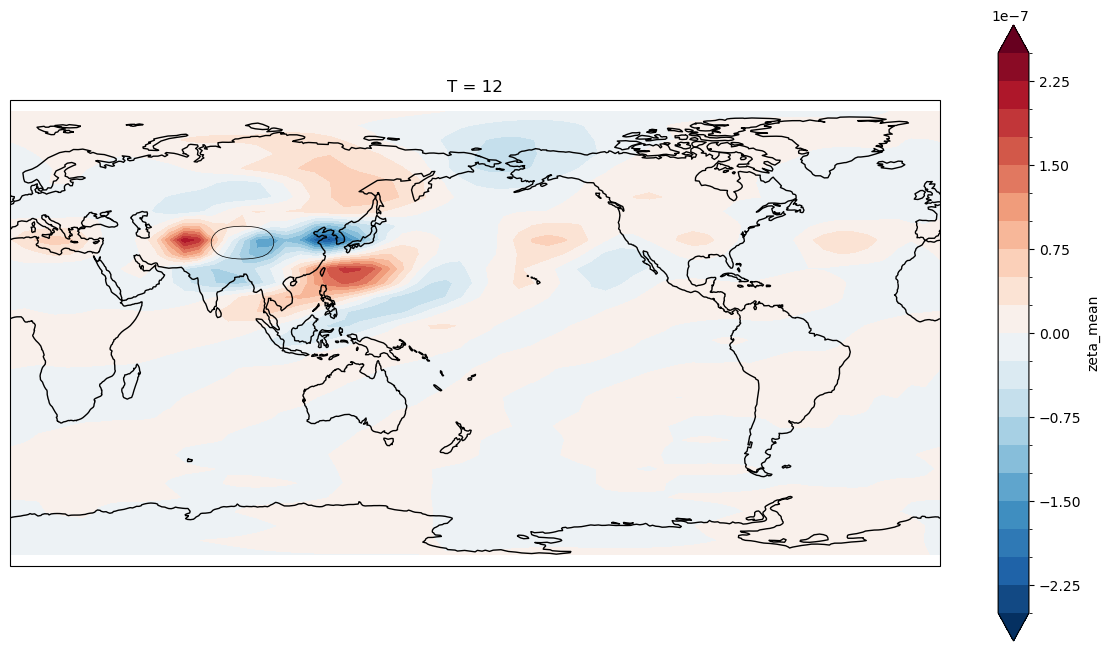

In [132]:
ax = quickplot(ideal_T32_nosigdot_x2.zeta_mean.sel(sigma=0.355,method='nearest'),levels=21)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

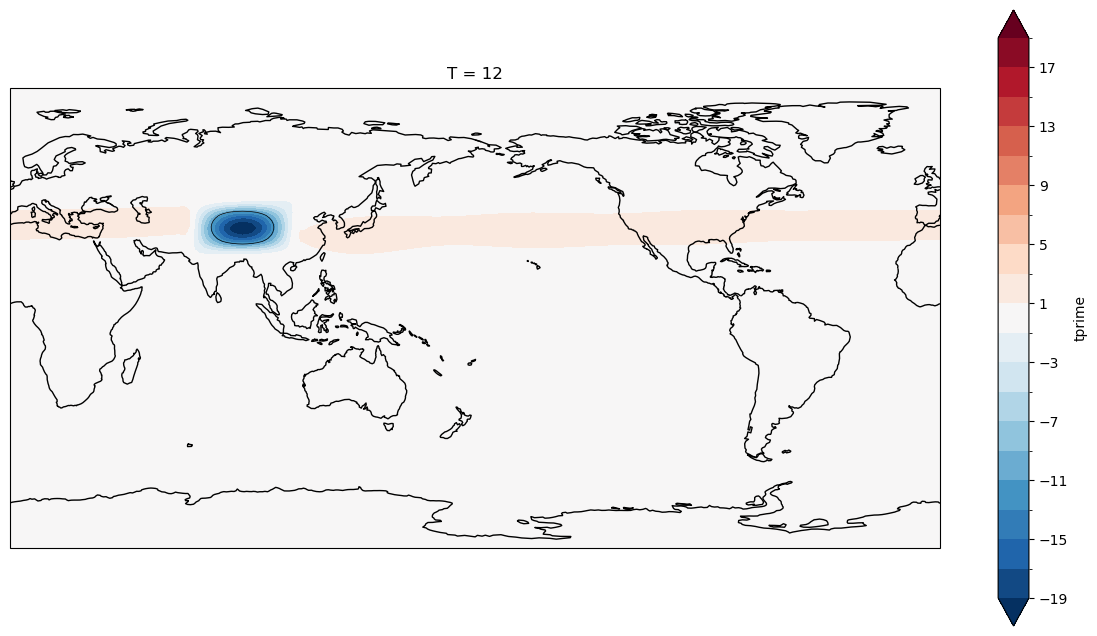

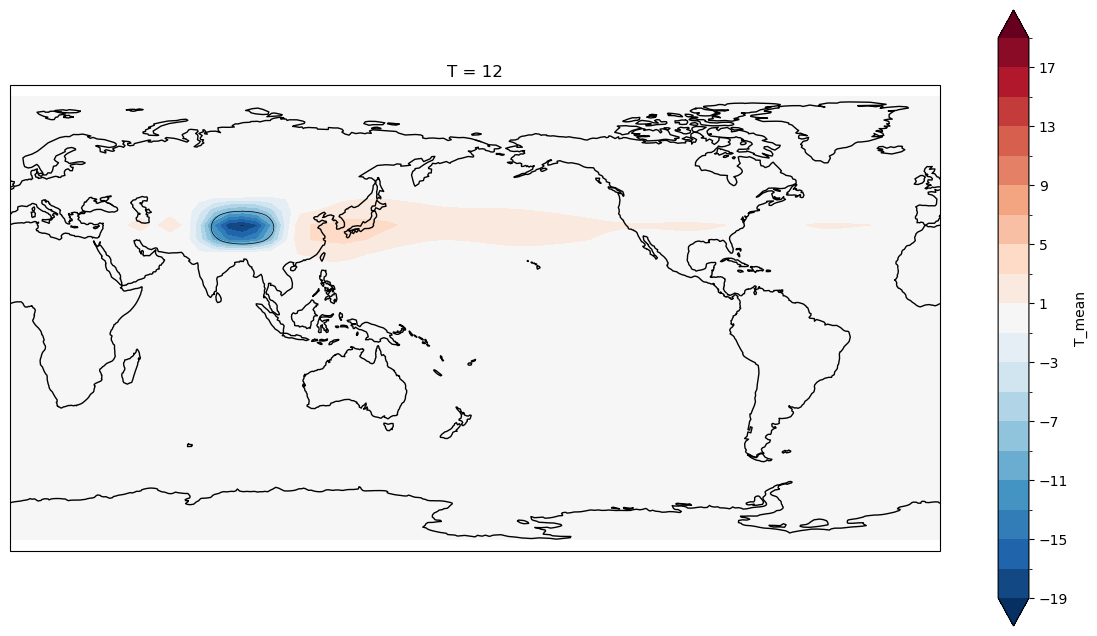

In [ ]:
ax = quickplot(100*ideal_sigma_itp.tprime.sel(sigma=0.355,method='nearest'),levels=np.arange(-19,20,2))
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

ax = quickplot(100*ideal_T32_2.T_mean.sel(sigma=0.355,method='nearest'),levels=np.arange(-19,20,2))
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

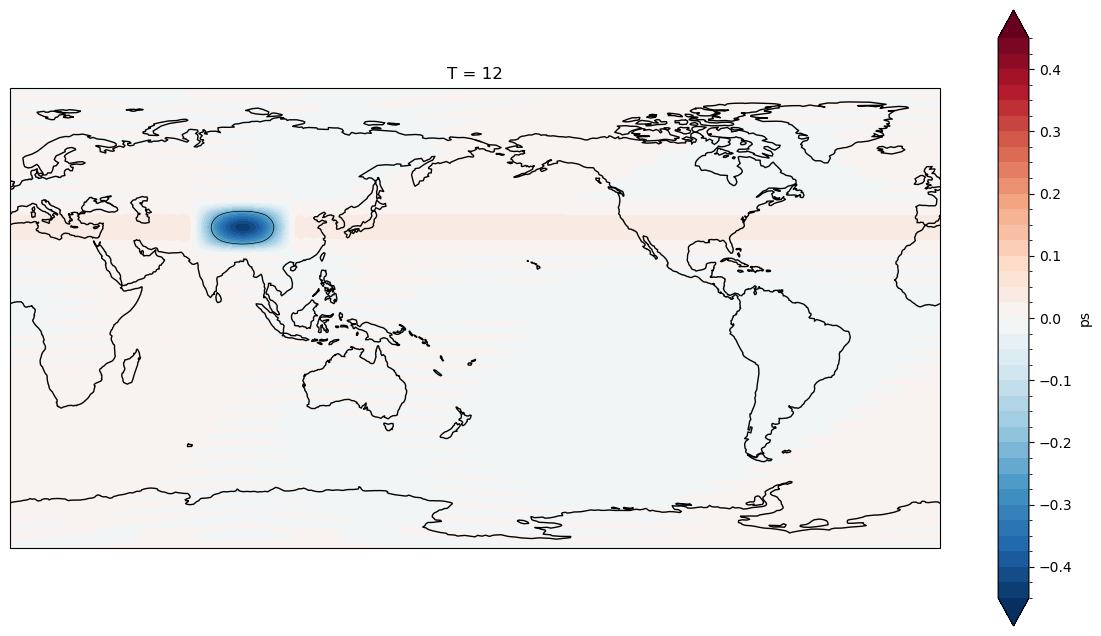

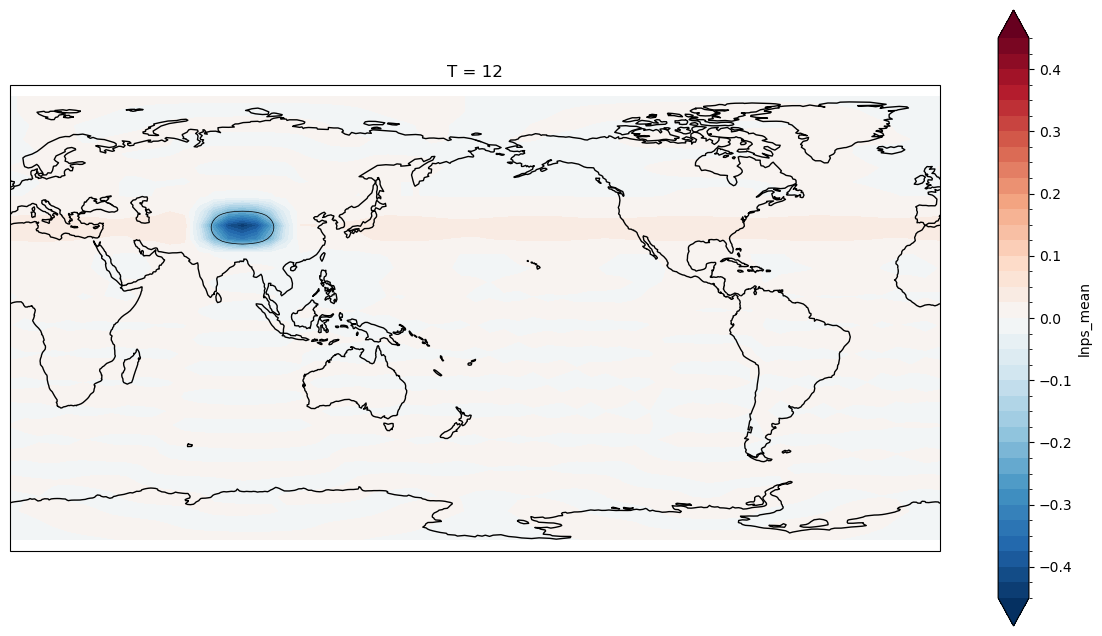

In [ ]:
ax = quickplot(100*ideal_sigma_itp.ps,levels=41)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

ax = quickplot(100*ideal_T32_2.lnps_mean,levels=41)
ideal_sigma.zstar.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20,40], colors='k', linewidths=0.5)

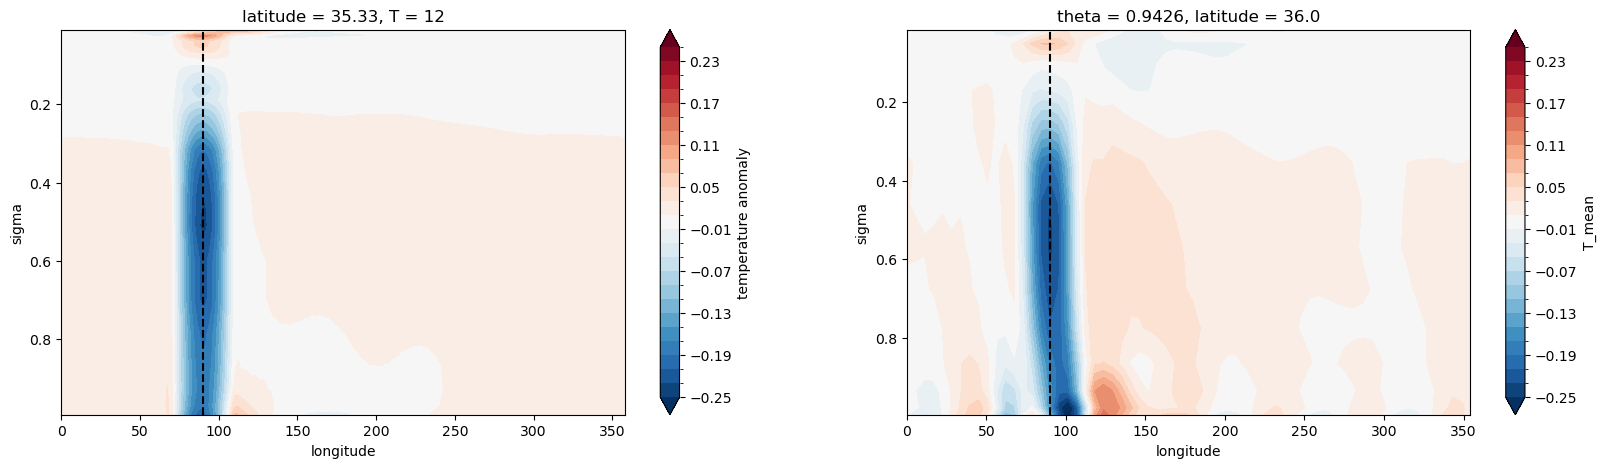

In [59]:
_,axs = plt.subplots(1,2,figsize=(20,5))
ideal_sigma.sel(latitude=35,method='nearest').tprime.plot.contourf(ax=axs[0],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
lon_180_to_360(ideal_T32_3.sel(latitude=35,method='nearest').T_mean).plot.contourf(ax=axs[1],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
for ax in axs:
    ax.axvline(90.,color='k',linestyle='--')

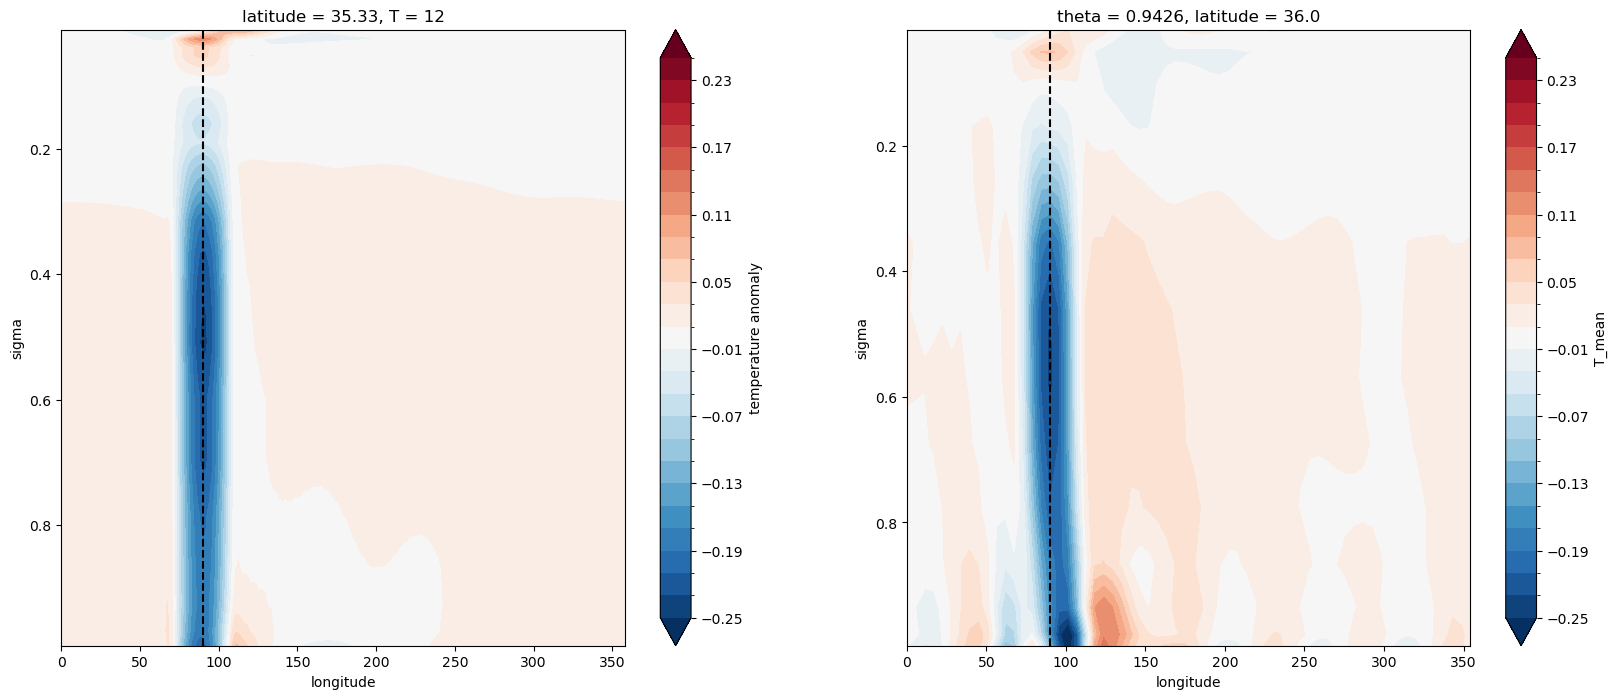

In [50]:
_,axs = plt.subplots(1,2,figsize=(20,8))
ideal_sigma.sel(latitude=35,method='nearest').tprime.plot.contourf(ax=axs[0],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
lon_180_to_360(ideal_T32_strongsigdot.sel(latitude=35,method='nearest').T_mean).plot.contourf(ax=axs[1],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
for ax in axs:
    ax.axvline(90.,color='k',linestyle='--')

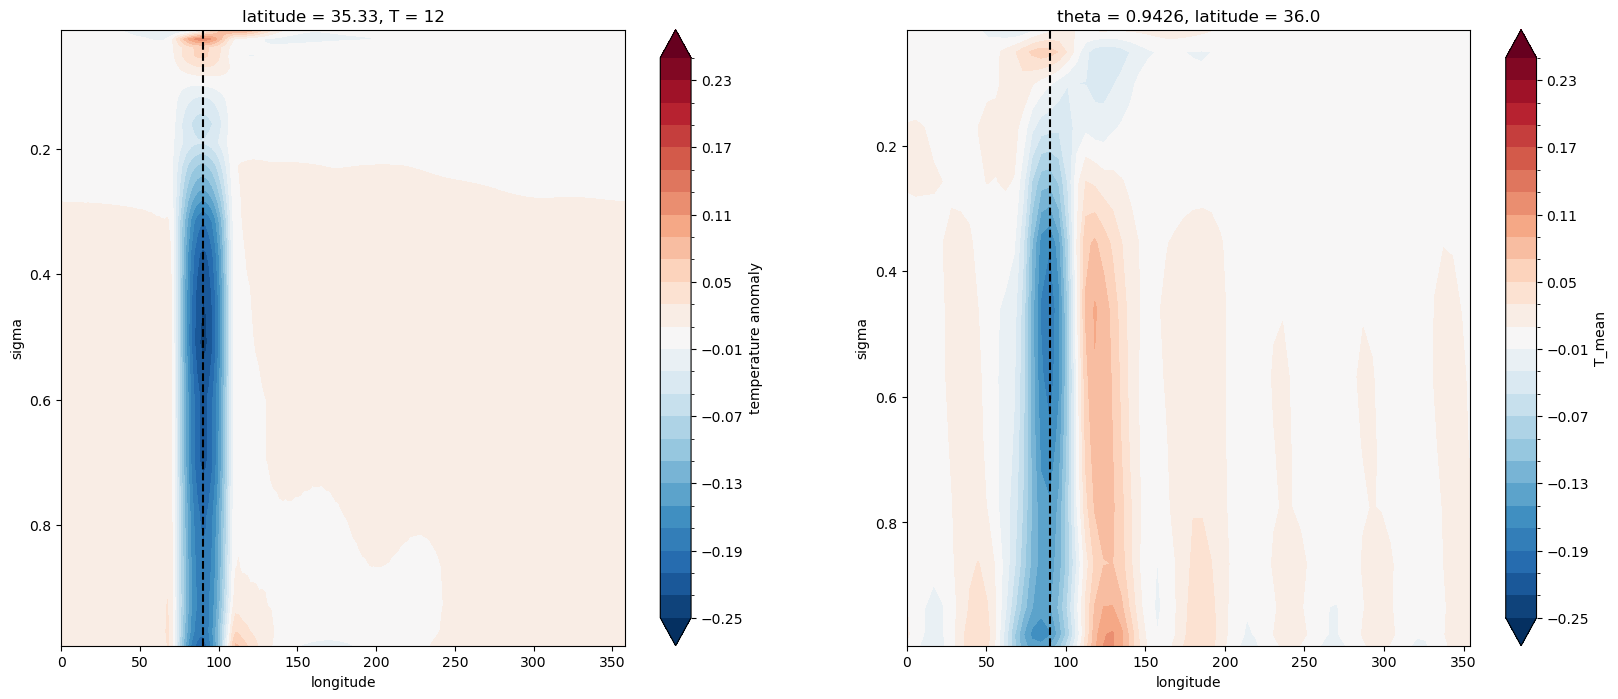

In [51]:
_,axs = plt.subplots(1,2,figsize=(20,8))
ideal_sigma.sel(latitude=35,method='nearest').tprime.plot.contourf(ax=axs[0],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
lon_180_to_360(ideal_T32_strongdiff.sel(latitude=35,method='nearest').T_mean).plot.contourf(ax=axs[1],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
for ax in axs:
    ax.axvline(90.,color='k',linestyle='--')

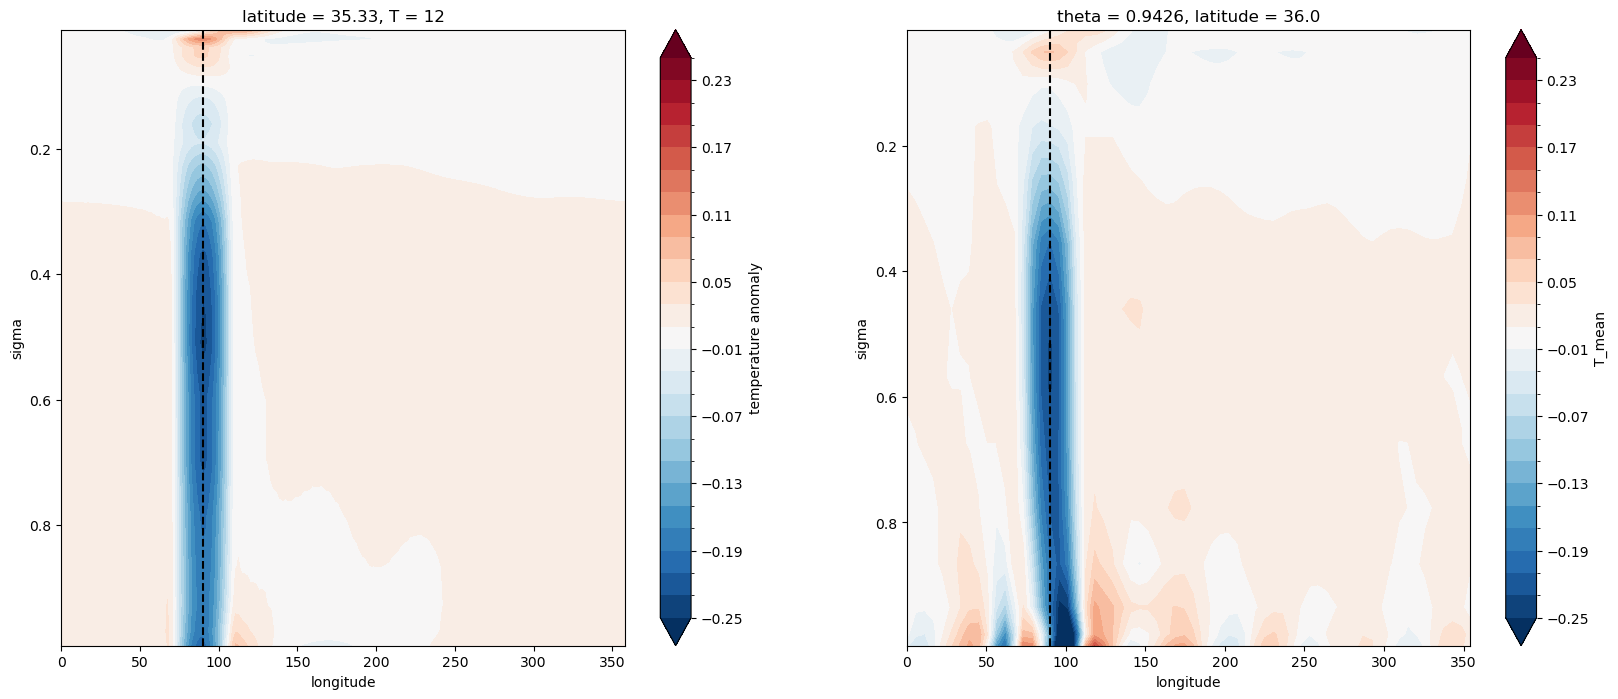

In [62]:
_,axs = plt.subplots(1,2,figsize=(20,8))
ideal_sigma.sel(latitude=35,method='nearest').tprime.plot.contourf(ax=axs[0],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
lon_180_to_360(ideal_T32_weakdiff.sel(latitude=35,method='nearest').T_mean).plot.contourf(ax=axs[1],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
for ax in axs:
    ax.axvline(90.,color='k',linestyle='--')

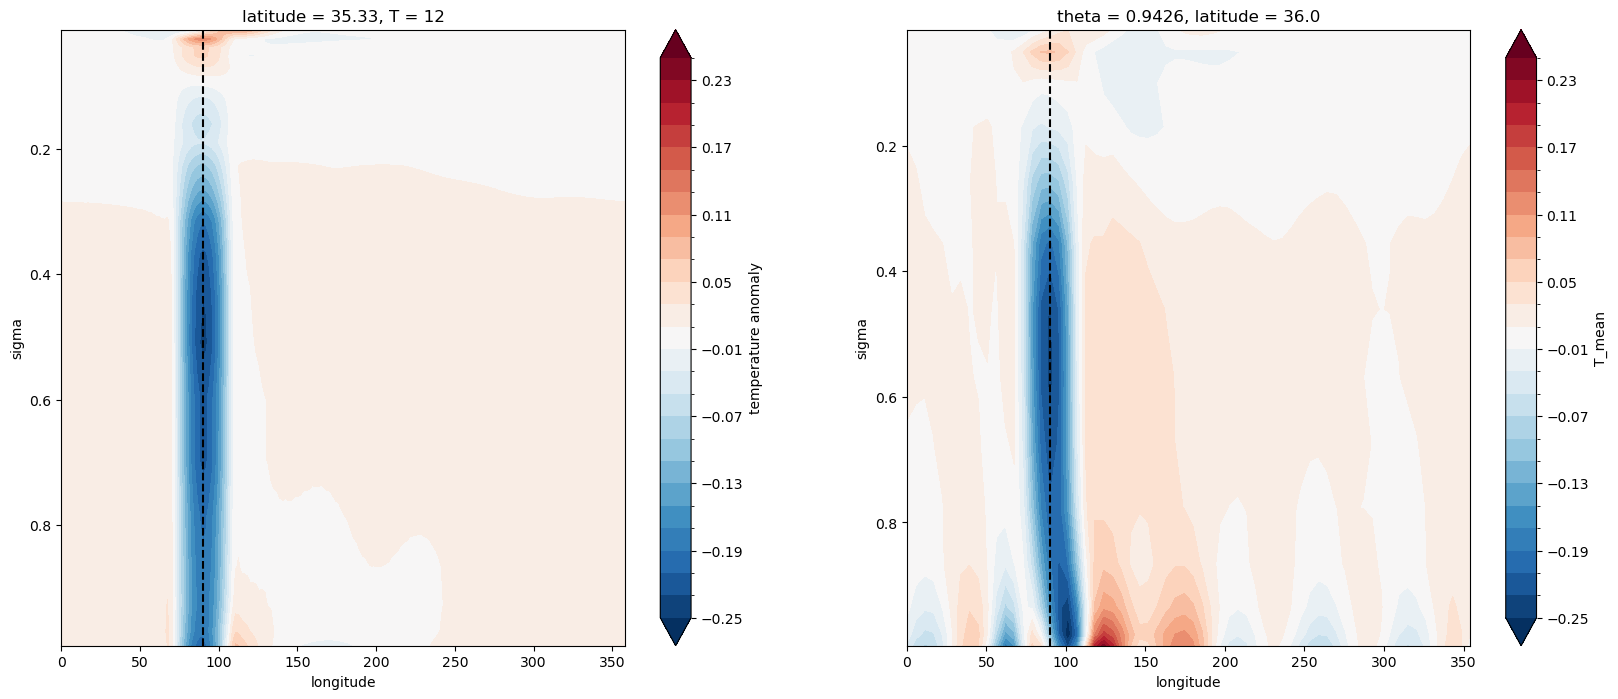

In [125]:
_,axs = plt.subplots(1,2,figsize=(20,8))
ideal_sigma.sel(latitude=35,method='nearest').tprime.plot.contourf(ax=axs[0],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
lon_180_to_360(ideal_T32_nosigdot.sel(latitude=35,method='nearest').T_mean).plot.contourf(ax=axs[1],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
for ax in axs:
    ax.axvline(90.,color='k',linestyle='--')

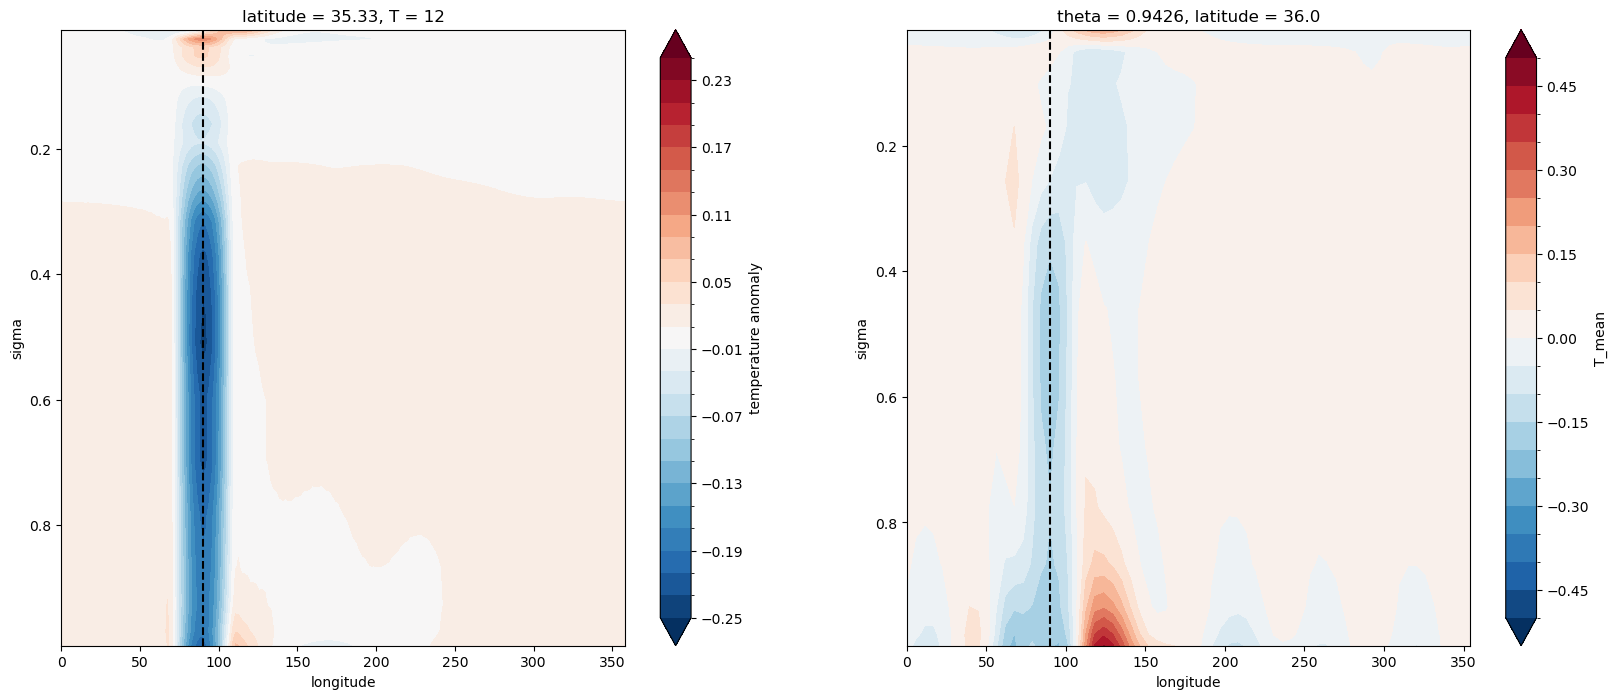

In [17]:
_,axs = plt.subplots(1,2,figsize=(20,8))
ideal_sigma.sel(latitude=35,method='nearest').tprime.plot.contourf(ax=axs[0],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
lon_180_to_360(ideal_T32_nosigdot_x2.sel(latitude=35,method='nearest').T_mean).plot.contourf(ax=axs[1],y='sigma',yincrease=False,levels = 21,extend='both')
for ax in axs:
    ax.axvline(90.,color='k',linestyle='--')

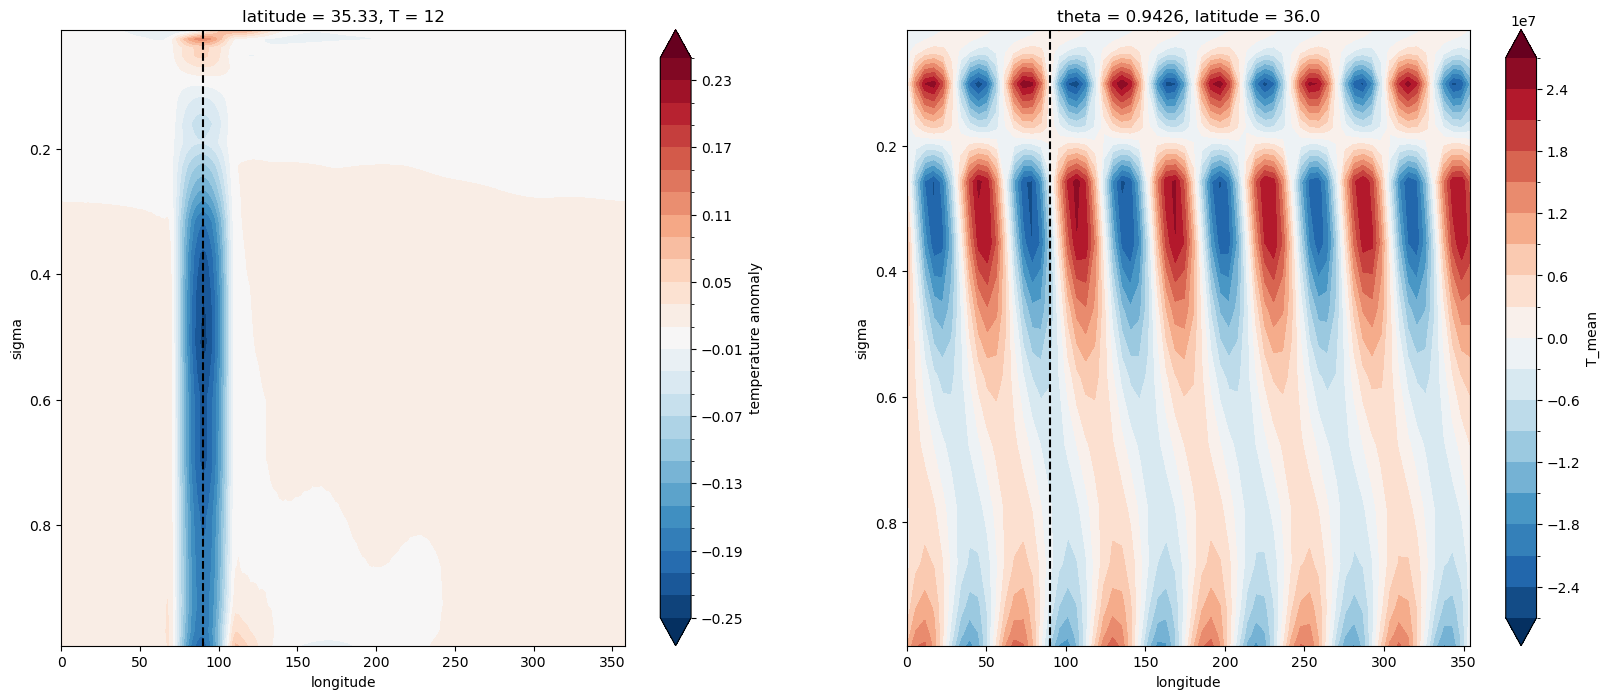

In [18]:
_,axs = plt.subplots(1,2,figsize=(20,8))
ideal_sigma.sel(latitude=35,method='nearest').tprime.plot.contourf(ax=axs[0],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
lon_180_to_360(ideal_T32_nosigdot_div10.sel(latitude=35,method='nearest').T_mean).plot.contourf(ax=axs[1],y='sigma',yincrease=False,levels = 21,extend='both')
for ax in axs:
    ax.axvline(90.,color='k',linestyle='--')

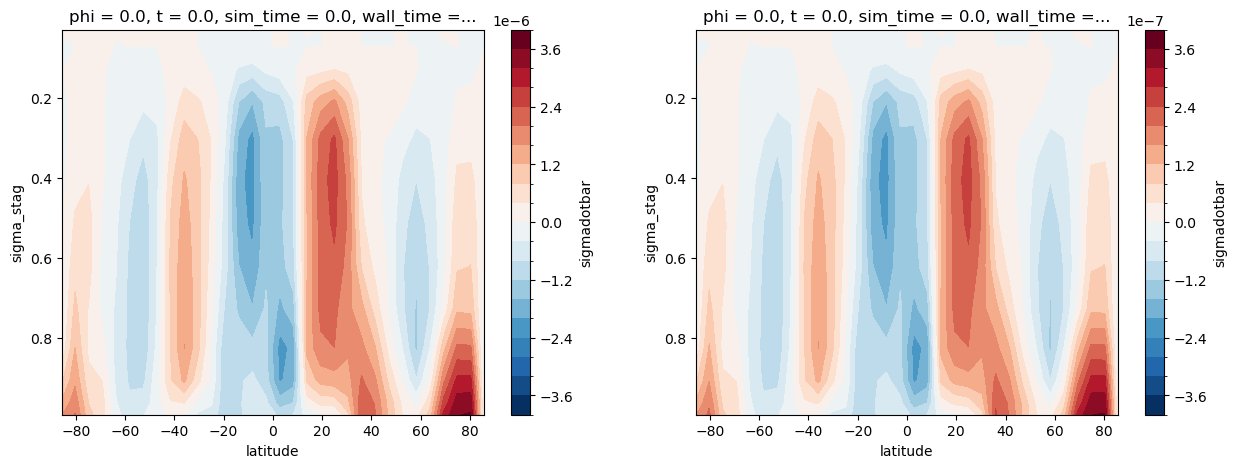

In [28]:
_,axs = plt.subplots(1,2,figsize=(15,5))
ideal_T32_strongsigdot.sigmadotbar[0].isel(longitude=0).plot.contourf(ax=axs[0],y='sigma_stag',yincrease=False,levels=21)
ideal_T32_3.sigmadotbar[0].isel(longitude=0).plot.contourf(ax=axs[1],y='sigma_stag',yincrease=False,levels=21)

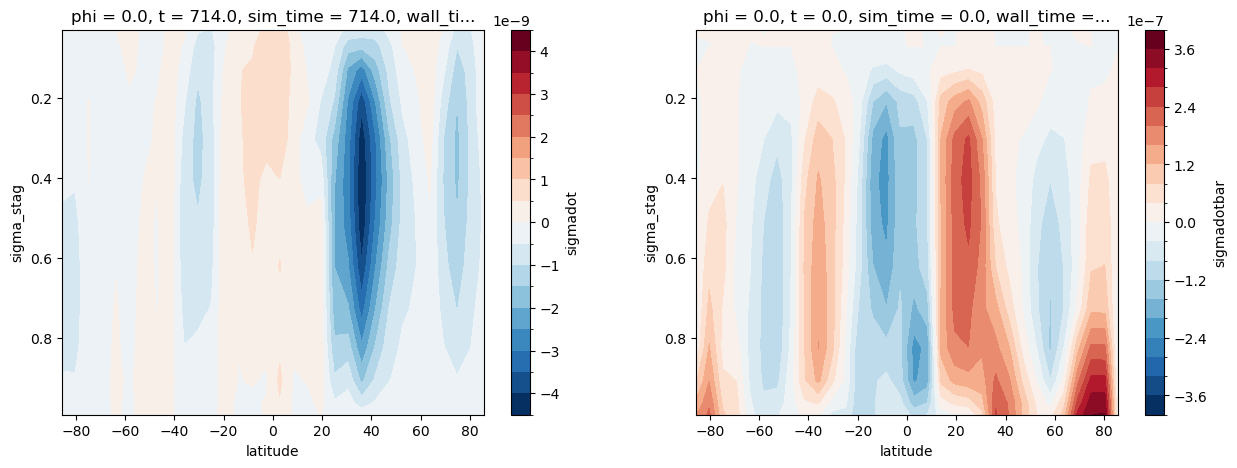

In [29]:
_,axs = plt.subplots(1,2,figsize=(15,5))
ideal_T32_strongsigdot.sigmadot[-1].isel(longitude=0).plot.contourf(ax=axs[0],y='sigma_stag',yincrease=False,levels=21)
ideal_T32_3.sigmadotbar[0].isel(longitude=0).plot.contourf(ax=axs[1],y='sigma_stag',yincrease=False,levels=21)

<GeoAxes: title={'center': 't = 714.0, sim_time = 714.0, wall_time = 160.8,...'}, xlabel='longitude', ylabel='latitude'>

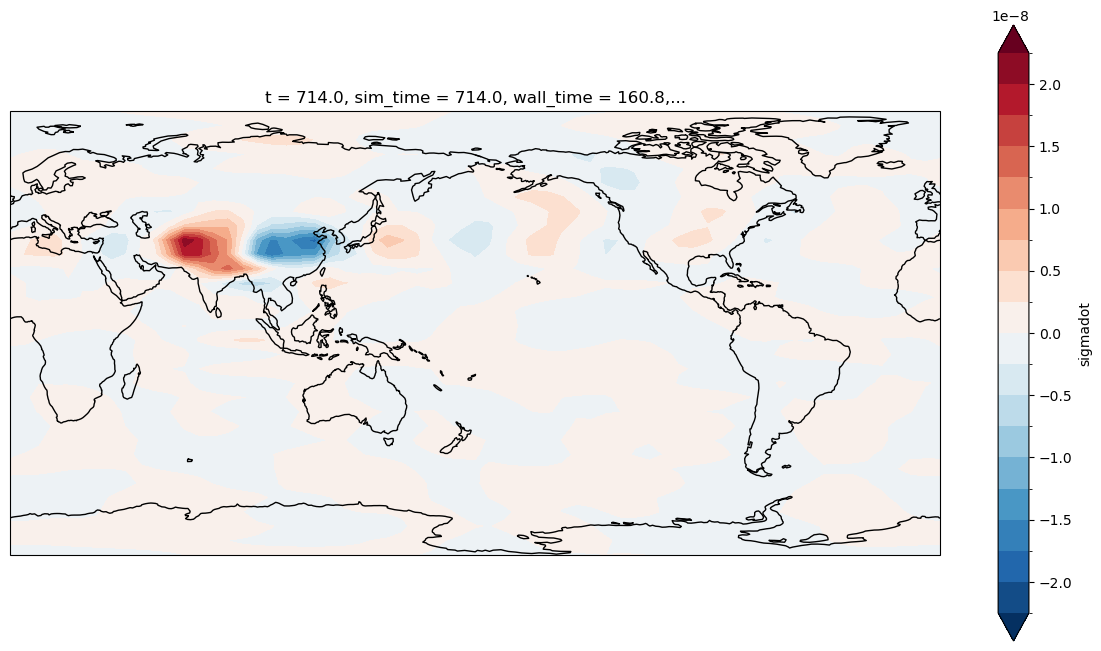

In [34]:
quickplot(ideal_T32_3.sigmadot[-1].sel(sigma_stag=0.355,method='nearest'),levels=21)

<GeoAxes: title={'center': 't = 714.0, sim_time = 714.0, wall_time = 160.2,...'}, xlabel='longitude', ylabel='latitude'>

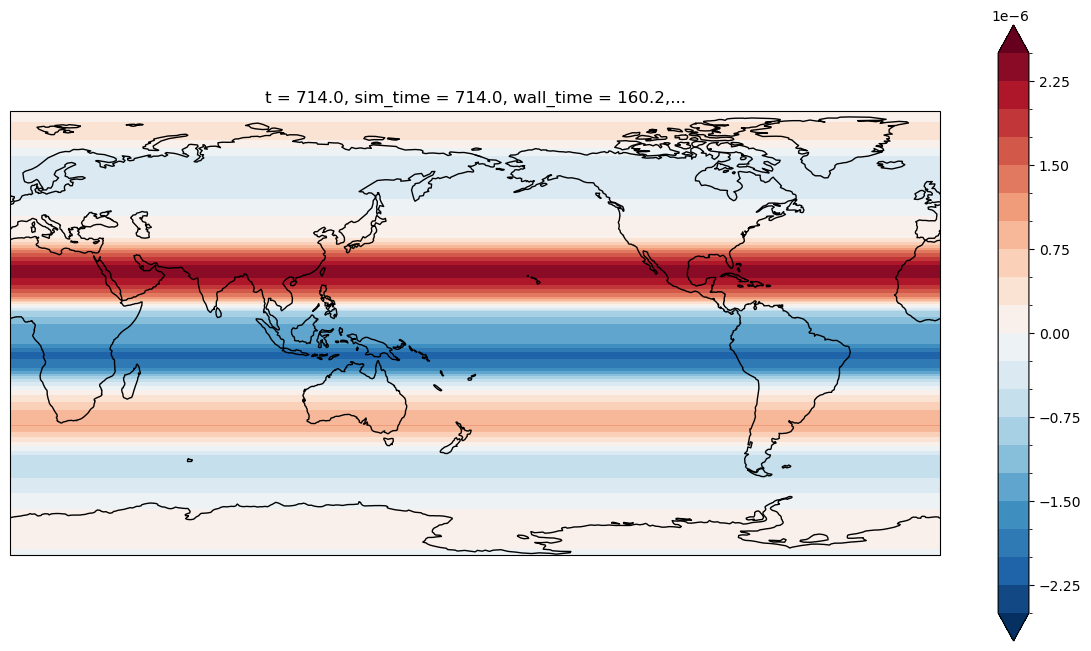

In [33]:
quickplot(ideal_T32_strongsigdot.sigmadotbar[-1].sel(sigma_stag=0.355,method='nearest').isel(longitude=0) *ideal_T32_strongsigdot.longitude**0 ,levels=21)

In [35]:
forcings = xr.open_dataset("ncep_jan_basic_state.nc")

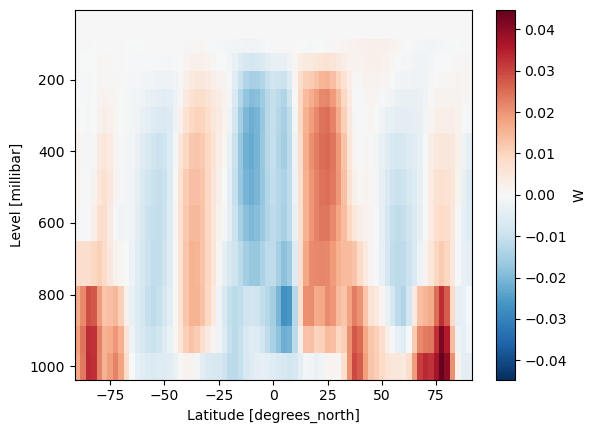

In [38]:
forcings.W.plot(y='pressure',yincrease=False)

In [45]:
ideal_sigma.DRAGU.values

array([7.7160496e-07, 7.7160496e-07, 7.7160496e-07, 7.7160496e-07,
       7.7160496e-07, 7.7160496e-07, 7.7160496e-07, 7.7160496e-07,
       7.7160496e-07, 7.7160496e-07, 7.7160496e-07, 7.7160496e-07,
       7.7160496e-07, 7.7160496e-07, 7.7160496e-07, 7.7160496e-07,
       7.7160496e-07, 7.7160496e-07, 7.7160496e-07, 7.7160496e-07,
       1.4467593e-06, 1.1574074e-05, 2.3148148e-05, 3.8580245e-05],
      dtype=float32)